# Iceberg Qualitative Plotting

Create sample molecule tree 

In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import yaml
import json
from collections import defaultdict

from ms_pred import common
from ms_pred.common import plot_utils
import ms_pred.magma.fragmentation as fe
from ms_pred.common.plot_utils import *
from ms_pred.dag_pred import joint_model

import networkx as nx
from networkx.drawing.nx_pydot import graphviz_layout
import pydot

set_style()


%load_ext autoreload
%autoreload 2

/home/samlg/.conda/envs/ms-gen/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def export_network_viz(frags, frag_to_id, id_to_frag, example_folder):
    """Export network visualization of predicted fragmentation tree.

    Args:
            frags (dict): Dictionary of predicted fragments.
            frag_to_id (dict): Dictionary mapping fragment to id.
            id_to_frag (dict): Dictionary mapping id to fragment.
            example_folder (Path): Path to example folder.

    """

    edges = [
        (frag_to_id[j], frag_to_id[key])
        for key, val in frags.items()
        for j in val["parents"]
        if j in frags
    ]

    graph = nx.DiGraph()
    graph.add_edges_from(edges)
    cmap = sns.light_palette(method_colors["ICEBERG"], reverse=False, as_cmap=True)

    node_intens = [max(frags[id_to_frag[i]]["intens"]) for i in graph.nodes]
    color_key = [cmap(i) for i in node_intens]

    pos = graphviz_layout(graph, prog="dot")
    fig = plt.figure(figsize=(6, 5), dpi=400)
    nx.draw_networkx(
        graph,
        pos=pos,
        node_size=50,  # with_labels=False,
        width=0.5,
        arrowsize=2,
        font_size=3,
        node_color=color_key,
        ax=fig.gca(),
        edgecolors="black",
        linewidths=0.3,
    )  # edge_color="b")
    fig.gca().axis("off")
    fig.savefig(
        example_folder / f"frag_tree_pred.pdf",
        dpi=400,
        bbox_inches="tight",
        transparent=True,
    )


def export_frag_mols(frags, frag_to_id, engine, example_folder, top_k=10):

    """Export molecules of predicted fragments.

    Args:
            frags (dict): Dictionary of predicted fragments.
            frag_to_id (dict): Dictionary mapping fragment to id.
            engine (FragmentEngine): Fragment engine.
            example_folder (Path): Path to example folder.
            top_k (int): Number of top fragments to export.

    """

    mol_frags_folder = example_folder / "mol_frags"
    mol_frags_folder.mkdir(exist_ok=True)

    # Sort frags by highest intensity
    sorted_frags = sorted(
        frags.items(), key=lambda x: max(x[1]["intens"]), reverse=True
    )
    for frag_hash, frag_entry in sorted_frags[:top_k]:
        frag = frag_entry["frag"]
        id_num = frag_to_id[frag_hash]
        draw_dict = engine.get_draw_dict(frag)
        keep_atoms = draw_dict["hatoms"]
        keep_bonds = draw_dict["hbonds"]
        mol = draw_dict["mol"]

        export_mol_highlight(
            mol=engine.mol,
            hatoms=keep_atoms,
            hbonds=keep_bonds,
            name=mol_frags_folder / f"mol_{id_num}.pdf",
            height=500,
            width=500,
        )
    # Export full mol
    export_mol(
        mol=engine.mol,
        name=mol_frags_folder / f"mol_full.pdf",
        height=500,
        width=500,
    )


def draw_single_mol(id_to_frag, frag_id, frags, engine):
    """Draw single molecule."""

    frag_hash = id_to_frag[frag_id]
    frag = frags[frag_hash]["frag"]
    draw_dict = engine.get_draw_dict(frag)
    keep_atoms = draw_dict["hatoms"]
    keep_bonds = draw_dict["hbonds"]
    mol = draw_dict["mol"]
    print(keep_atoms, keep_bonds)
    Chem.Kekulize(mol)
    drawing = Draw.MolToImage(mol, highlightAtoms=keep_atoms, highlightBonds=keep_bonds)
    return drawing


def draw_fig(
    new_list,
    true_spec,
    example_folder,
    frag_to_id,
    ex_spec,
    engine,
    figsize=(2.1, 1.4),
    top_k=10,
    add_numbers=True,
    linewidth=1.0,
):

    fig = plt.figure(figsize=(figsize), dpi=300)
    ax = fig.gca()

    # Get top 10
    top_entries = sorted(new_list, key=lambda x: x["inten"])[::-1]

    for ind, entry in enumerate(top_entries):
        label_kwargs = {"label": "ICEBERG"} if ind == 0 else {}
        ax.vlines(
            x=entry["mz"],
            ymin=0,
            ymax=entry["inten"],
            color=method_colors.get("ICEBERG"),
            linewidth=linewidth,
            **label_kwargs,
        )

        if ind < top_k and add_numbers:
            temp_hash = entry["frag_hash"]
            cur_id = frag_to_id[temp_hash]
            ax.text(
                x=entry["mz"] - 2,
                y=entry["inten"] + 0.2,
                s=f"{cur_id}",
                fontsize=4,
                rotation=90,
            )

    mz, inten = (
        true_spec["output_tbl"]["formula_mass_no_adduct"],
        true_spec["output_tbl"]["rel_inten"],
    )
    for ind, (m, i) in enumerate(zip(mz, inten)):
        label_kwargs = {"label": "True"} if ind == 0 else {}
        ax.vlines(
            x=m,
            ymin=0,
            ymax=-i,
            color="black",
            linewidth=linewidth,
            **label_kwargs,
        )
    mol_weight = engine.full_weight
    ax.axhline(y=0, xmin=0, xmax=1, color="black", linewidth=linewidth / 2)
    ax.set_xlabel("M/Z")
    ax.set_ylabel("Intensity")
    ax.set_title(f"Spectra: {ex_spec}")
    ax.set_ylim([-1.5, 1.5])
    ax.set_xlim([75, mol_weight + 25])
    ax.set_yticklabels([abs(i) for i in ax.get_yticks()])
    ax.legend(**legend_params, loc="upper left")
    set_size(*figsize, ax)

    fig.savefig(
        example_folder / f"pred_spec.pdf",
        dpi=300,
        bbox_inches="tight",
        transparent=True,
    )
    with open(example_folder / f"info_{ex_spec}.txt", "w") as fp:
        fp.write(engine.smiles)
    mol_obj = Chem.MolFromSmiles(engine.smiles)
    plot_utils.export_mol(
        mol_obj, example_folder / f"{ex_spec}_mol.pdf", width=100, height=100
    )

Plot some test spectra examples from NIST20 


In [3]:
dataset_name = "canopus_train_public"
data_folder = Path(f"../data/spec_datasets/{dataset_name}/")
magma_folder = data_folder / "magma_outputs/magma_tree"
labels = data_folder / "labels.tsv"
split_file = data_folder / "splits/split_1.tsv"

In [4]:
# Load test split and labels
split_df = pd.read_csv(split_file, sep="\t")
labels_df = pd.read_csv(labels, sep="\t")

# Get all test specs from split df
test_specs = split_df[split_df["Fold_0"] == "test"]["spec"].values

# Subset labels df based upon test specs
test_labels_df = labels_df[labels_df["spec"].isin(test_specs)]

In [6]:
# Get best models
inten_ckpt = f"../results/dag_inten_{dataset_name}/split_1_rnd1/version_0/best.ckpt"
gen_ckpt = f"../results/dag_{dataset_name}/split_1_rnd1/version_0/best.ckpt"

# Load joint model
model = joint_model.JointModel.from_checkpoints(
    inten_checkpoint=inten_ckpt, gen_checkpoint=gen_ckpt
)

/home/samlg/.conda/envs/ms-gen/lib/python3.8/site-packages/dgl/backend/pytorch/tensor.py:46: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /opt/conda/conda-bld/pytorch_1631630839582/work/torch/csrc/utils/tensor_numpy.cpp:180.)
  return th.as_tensor(data, dtype=dtype)
/tmp/ipykernel_3079306/2713323580.py:171: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([abs(i) for i in ax.get_yticks()])
/tmp/ipykernel_3079306/2713323580.py:171: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([abs(i) for i in ax.get_yticks()])
/tmp/ipykernel_3079306/27

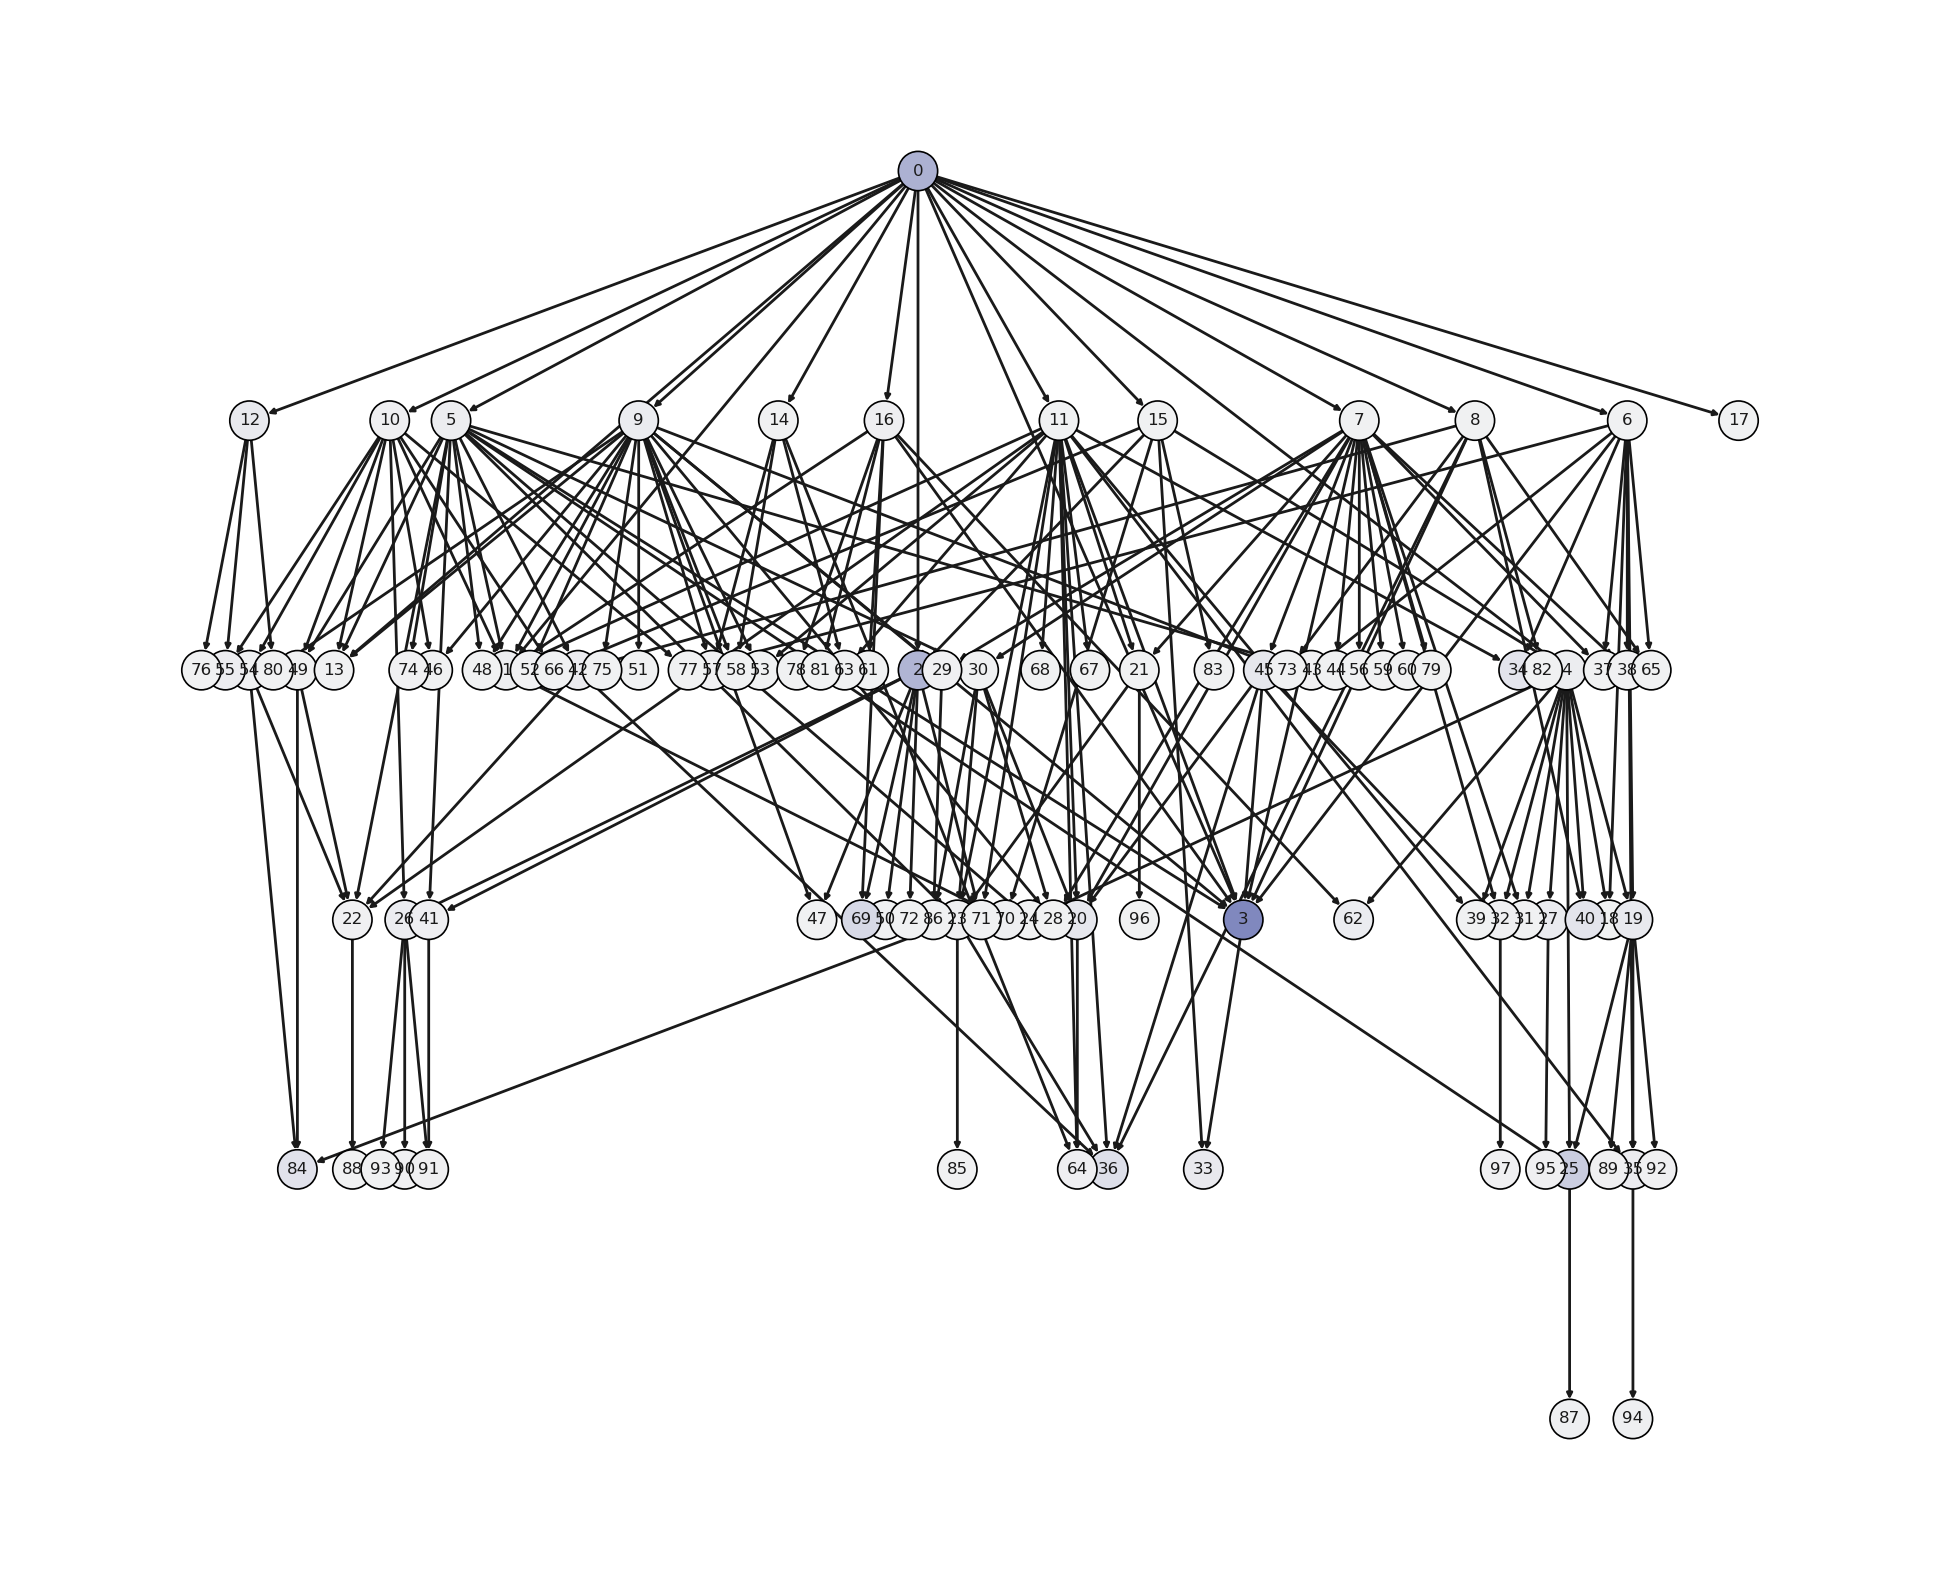

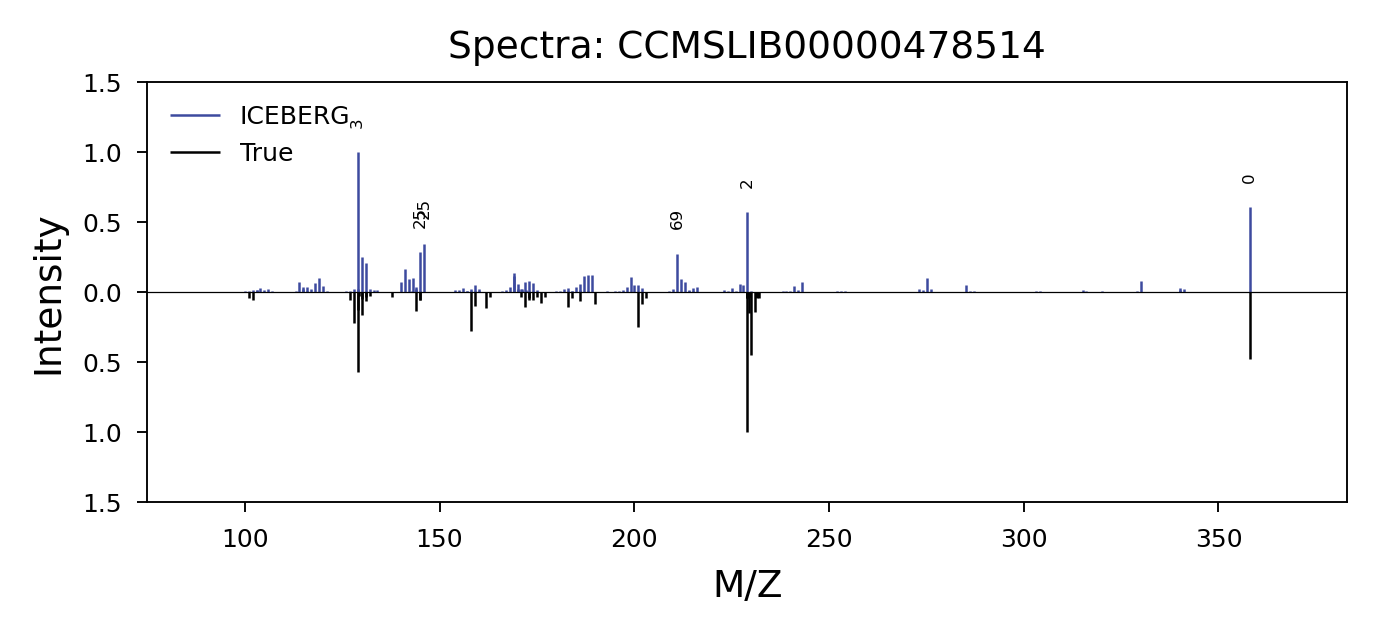

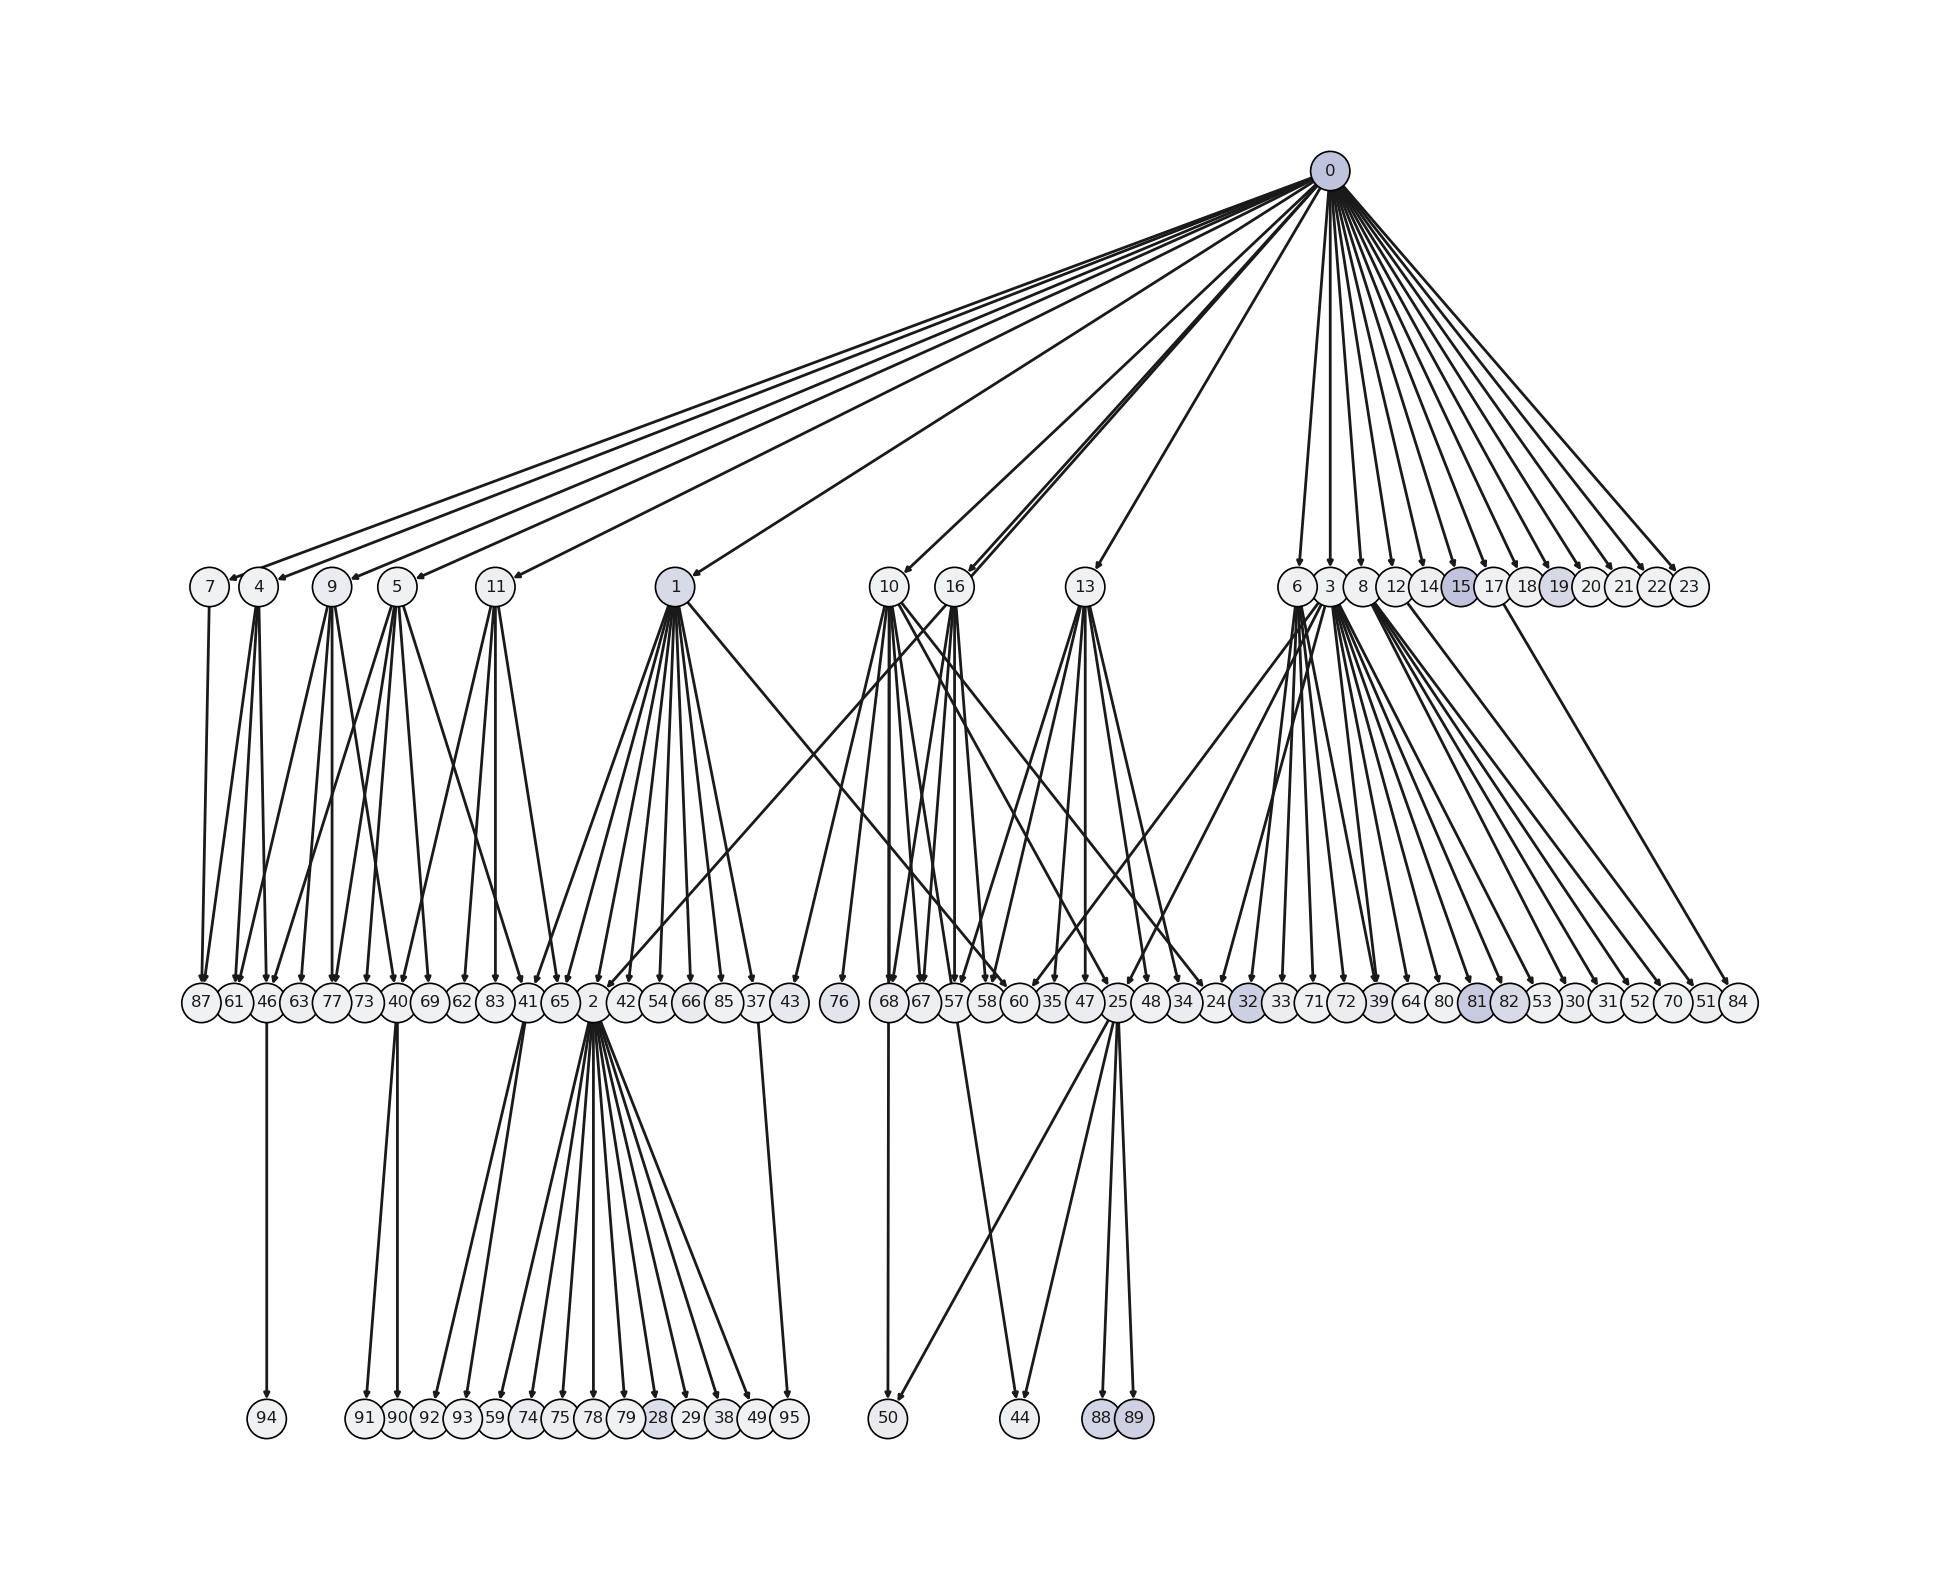

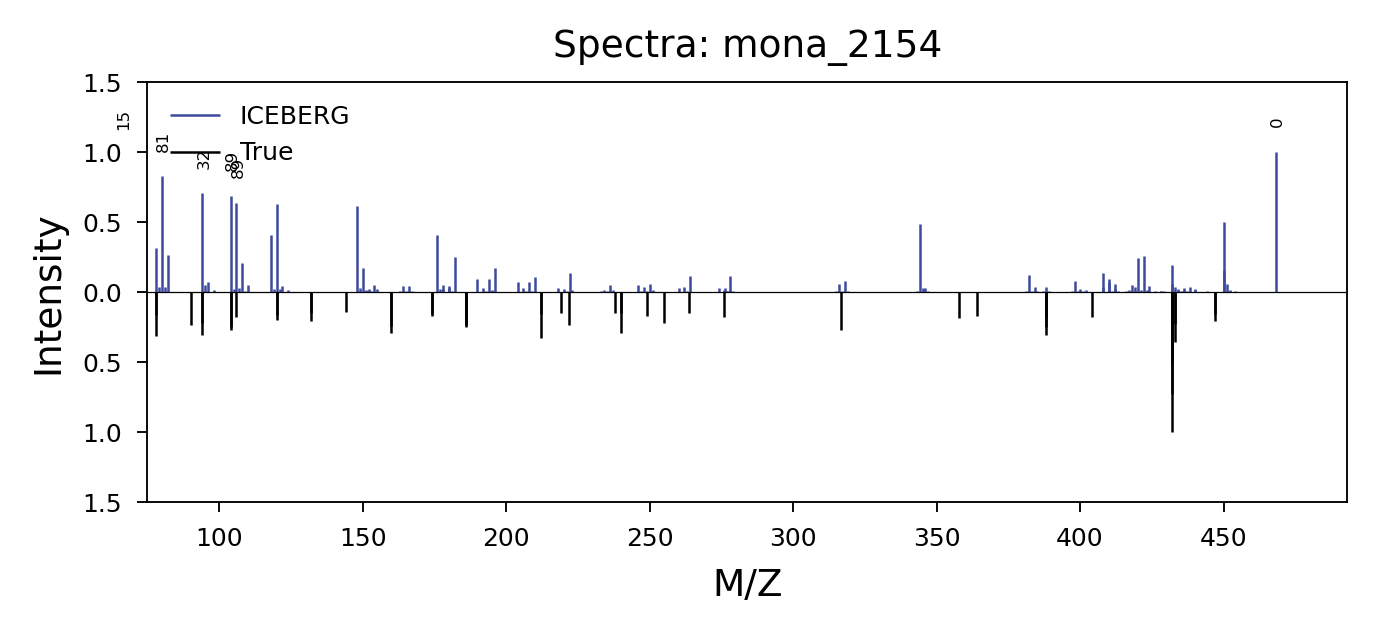

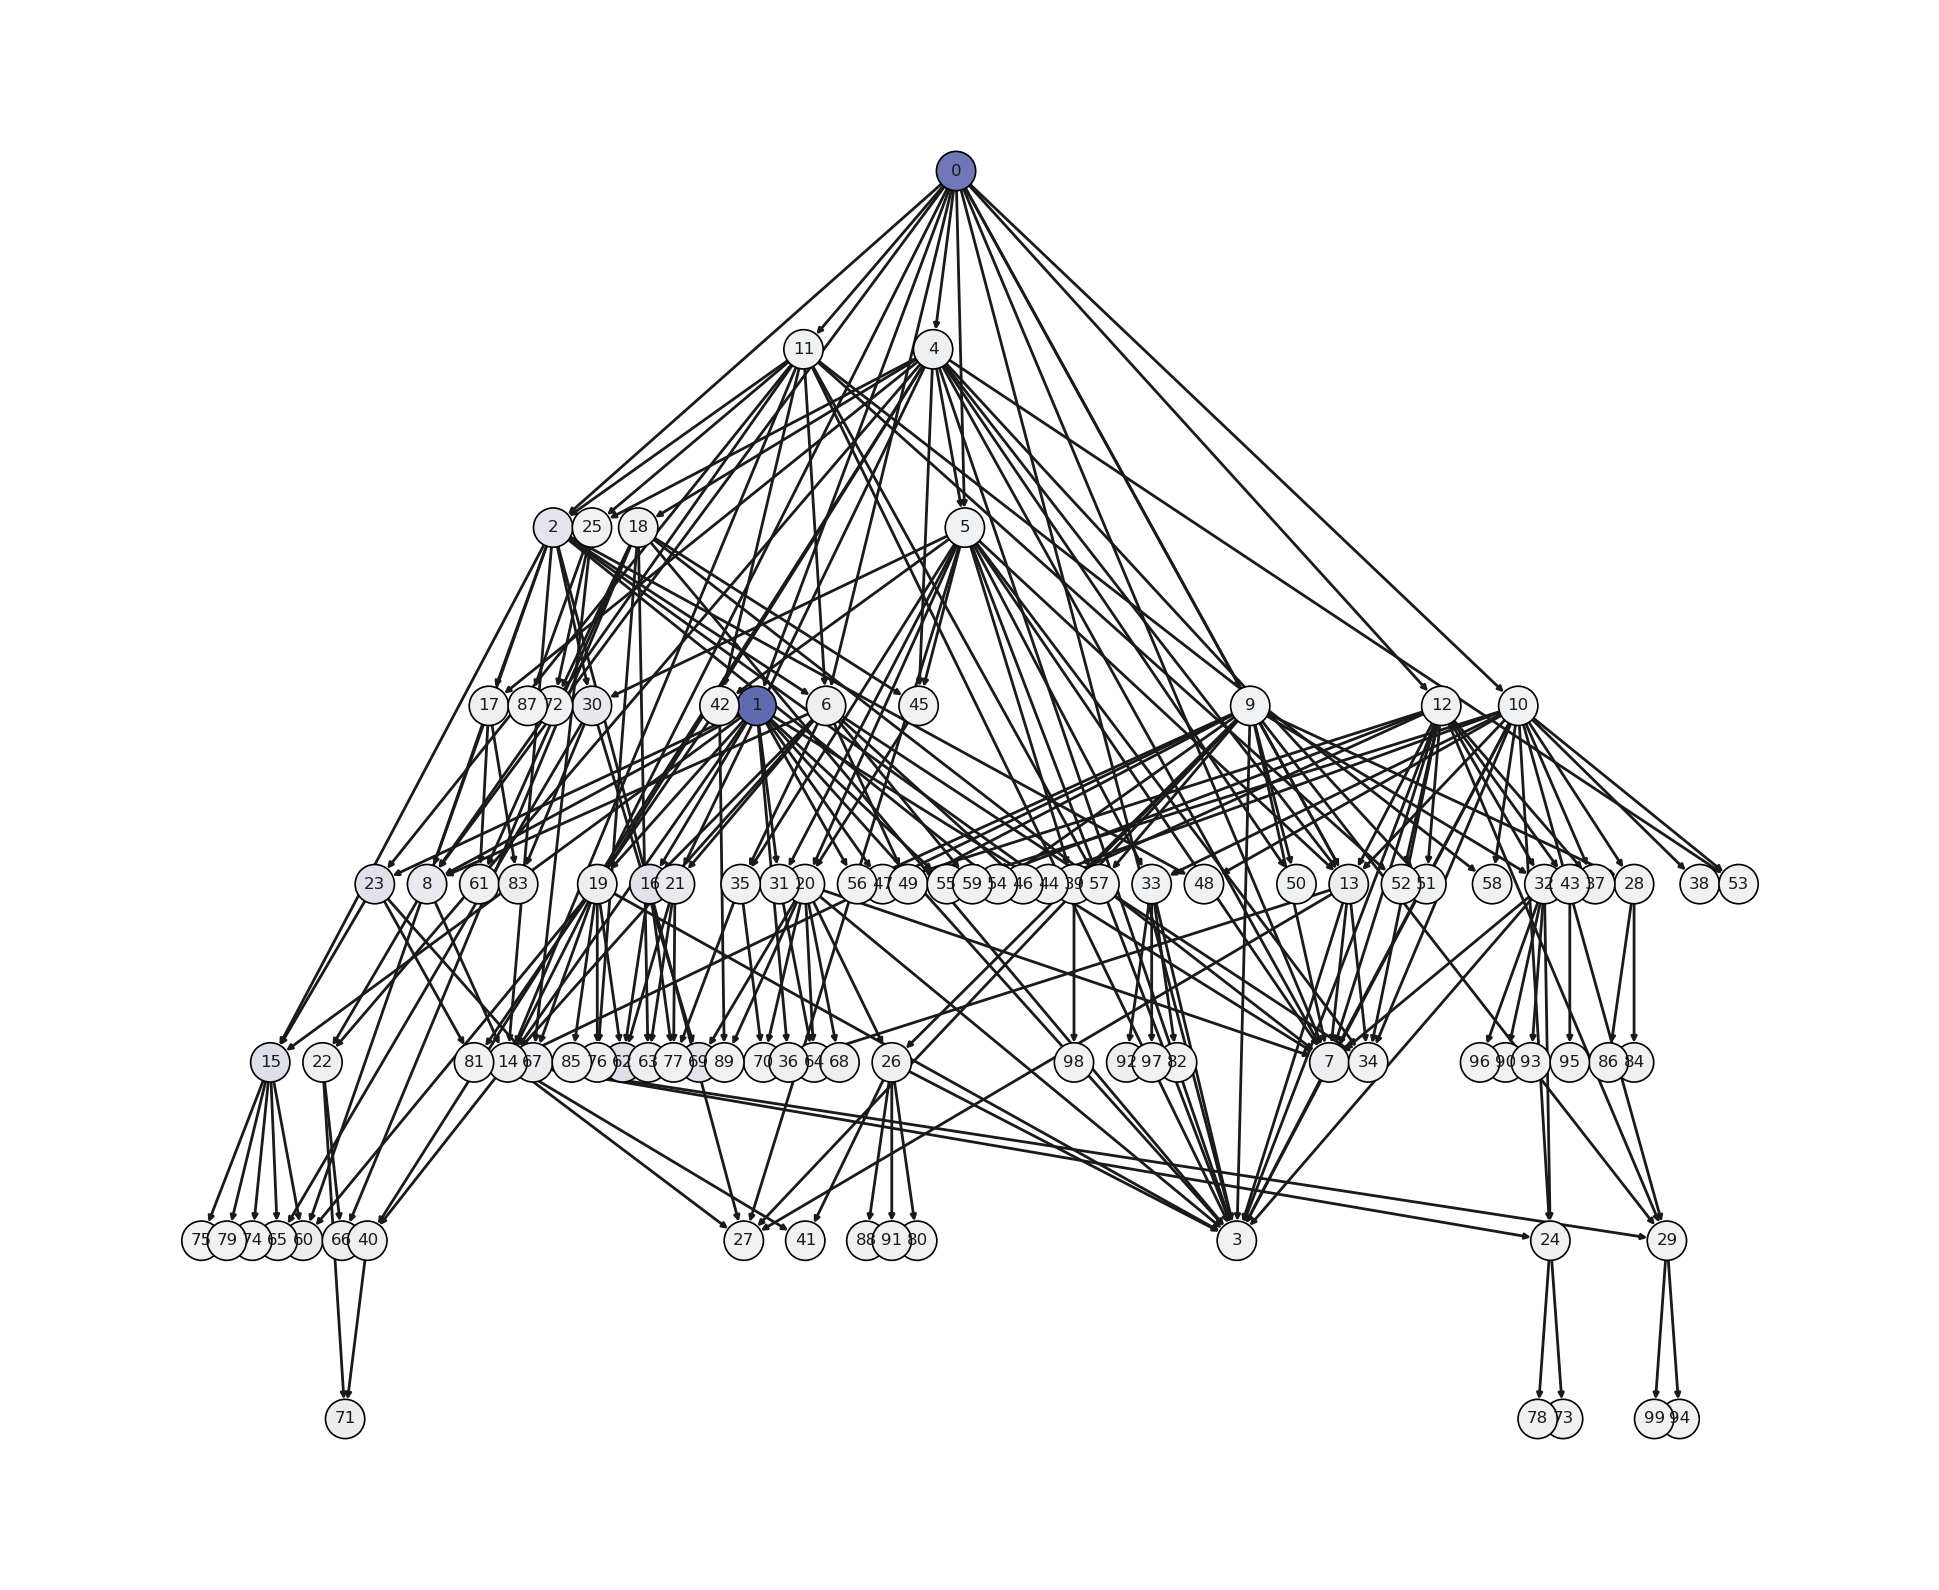

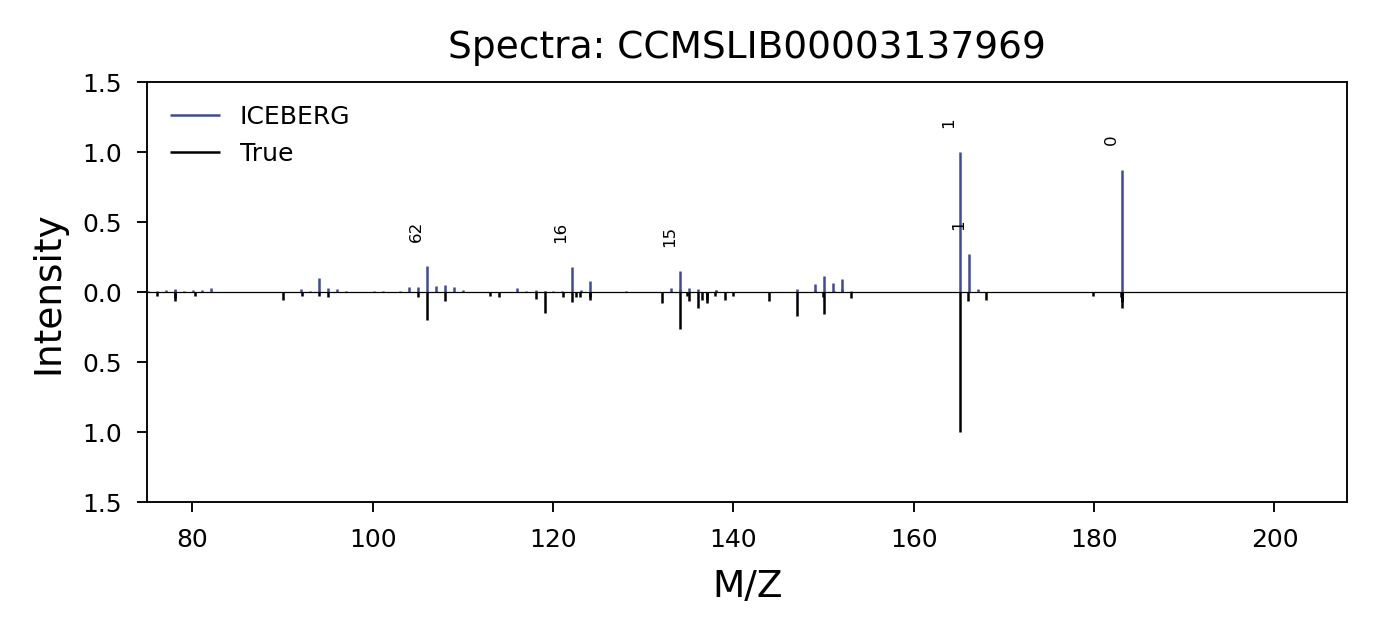

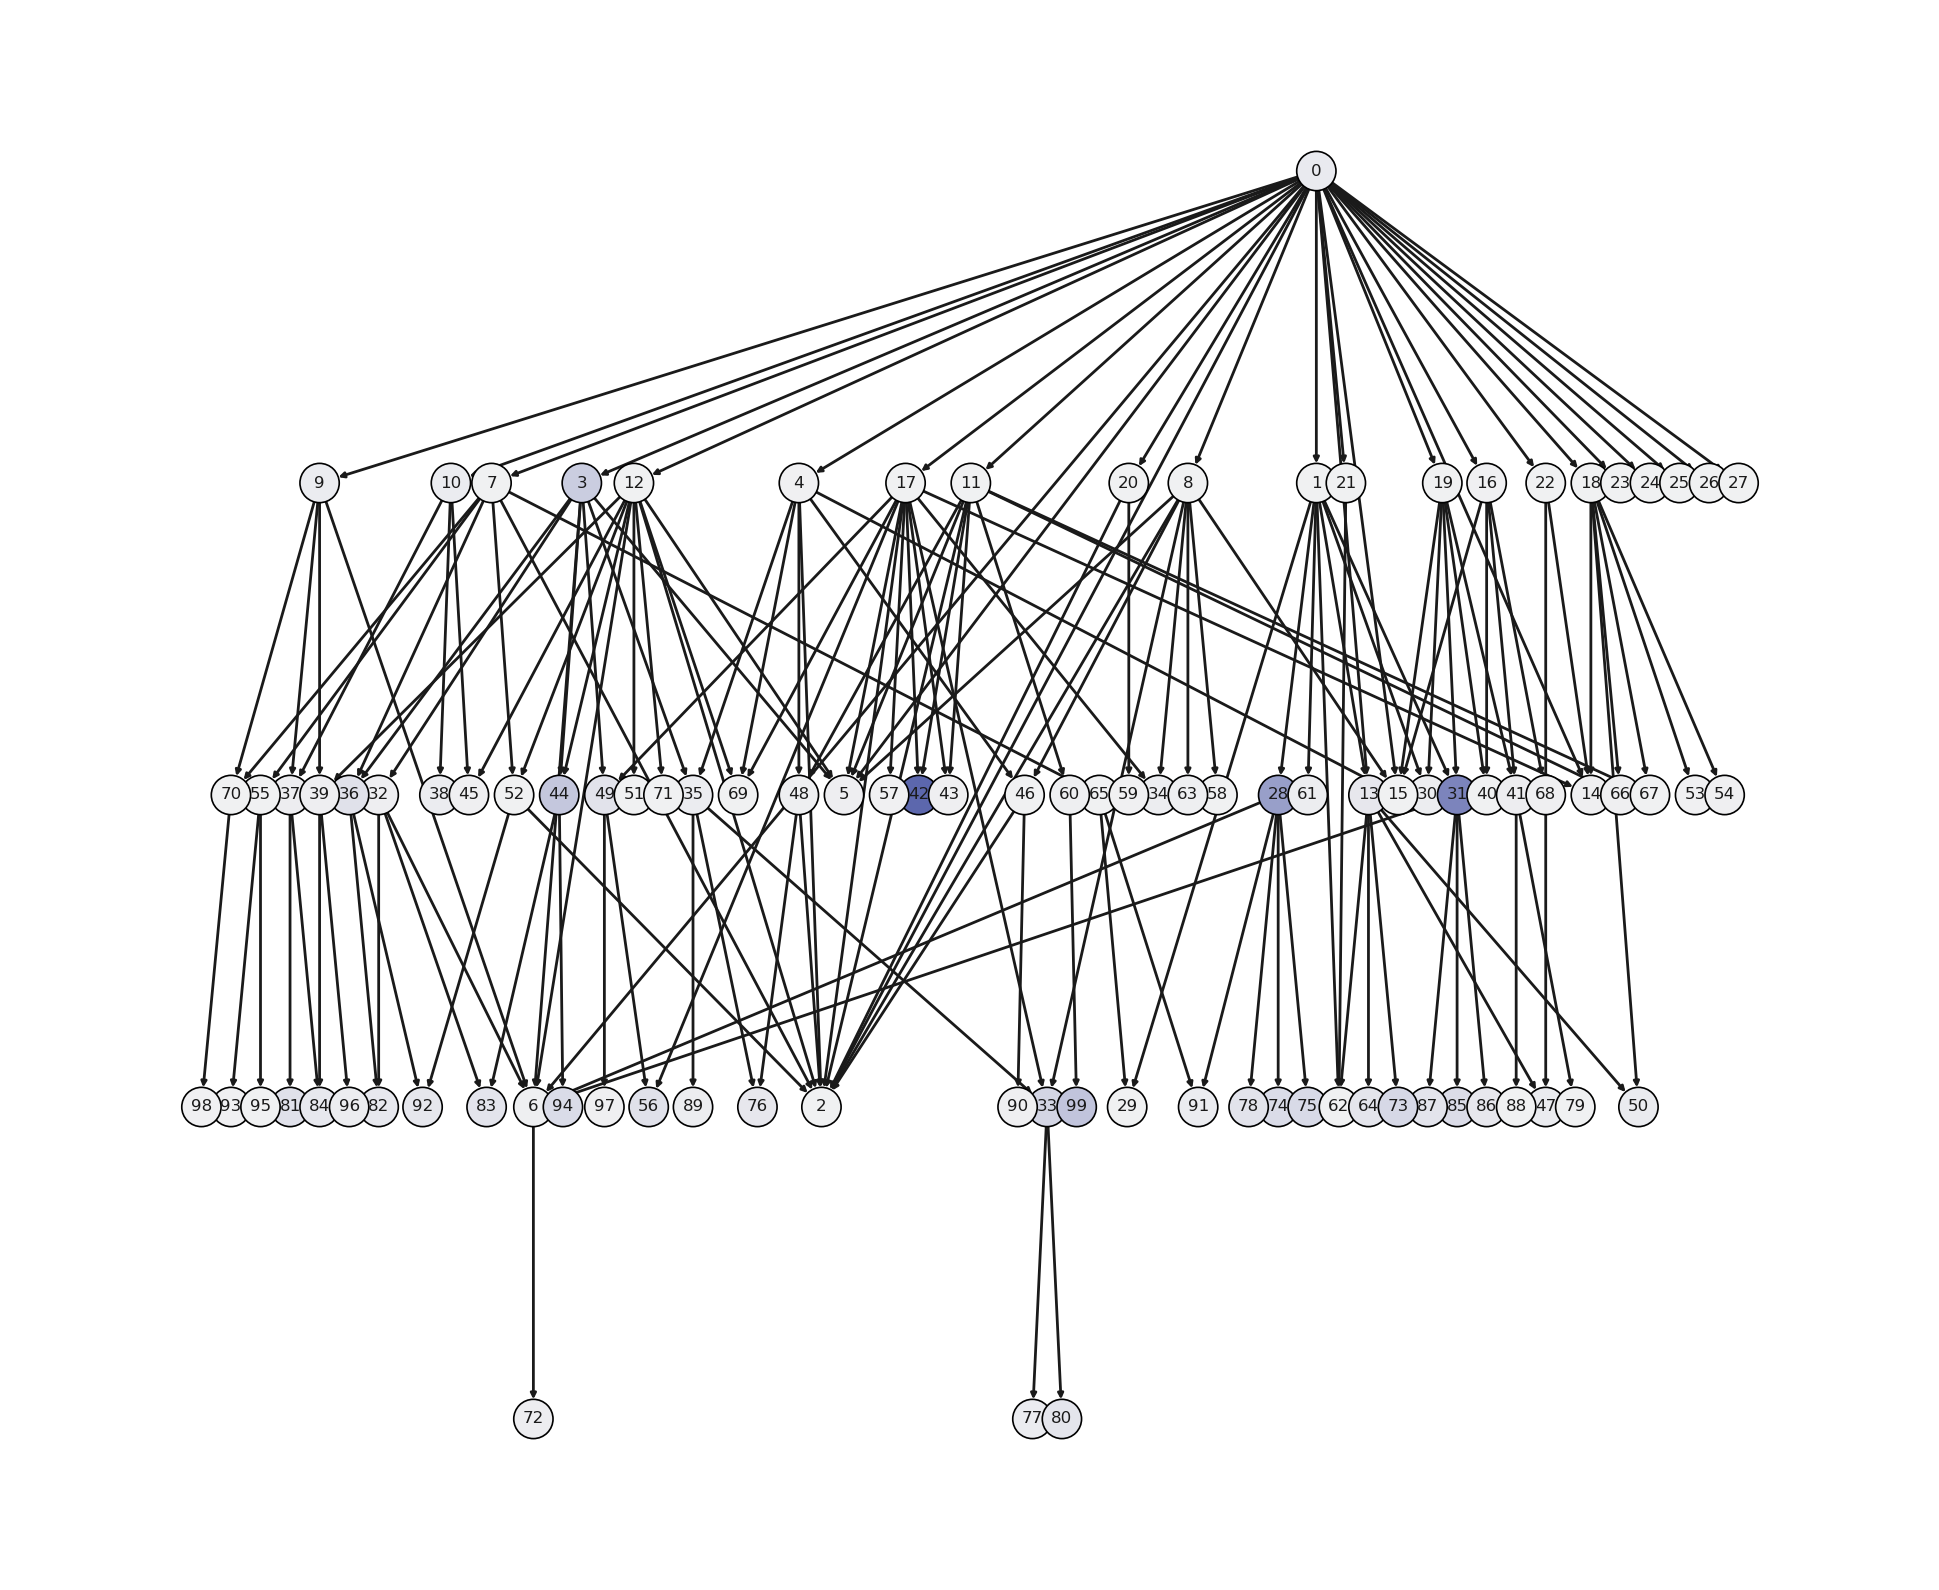

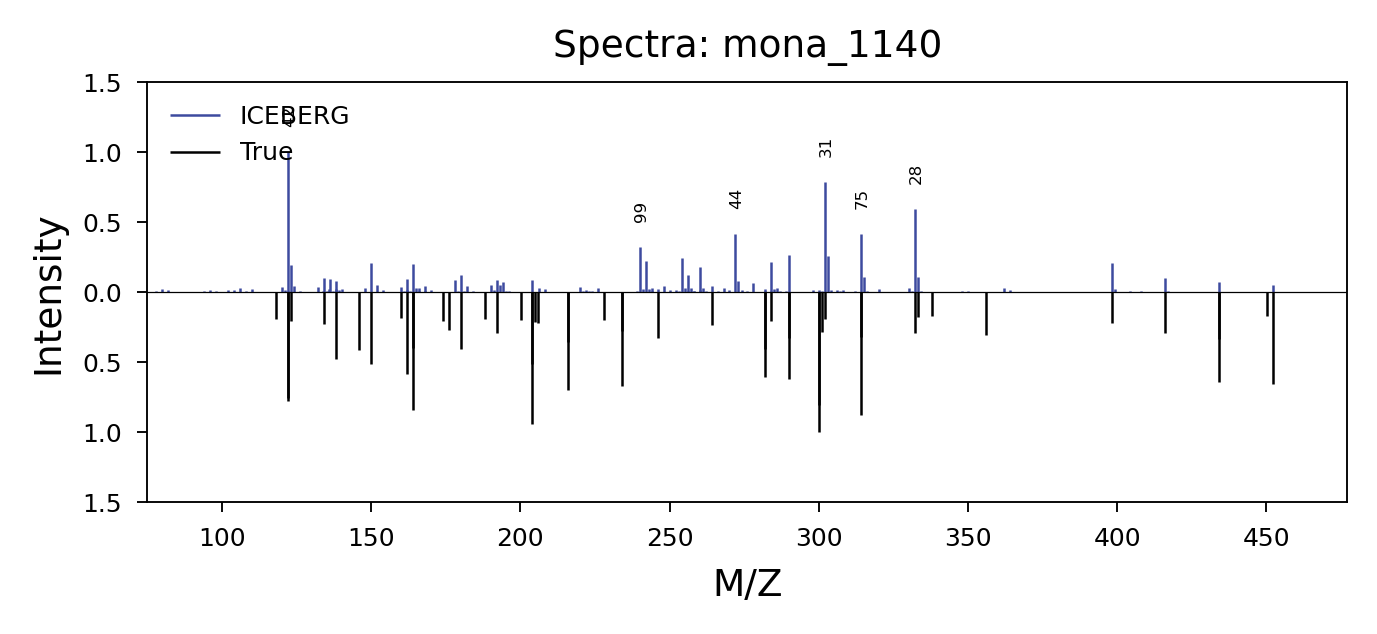

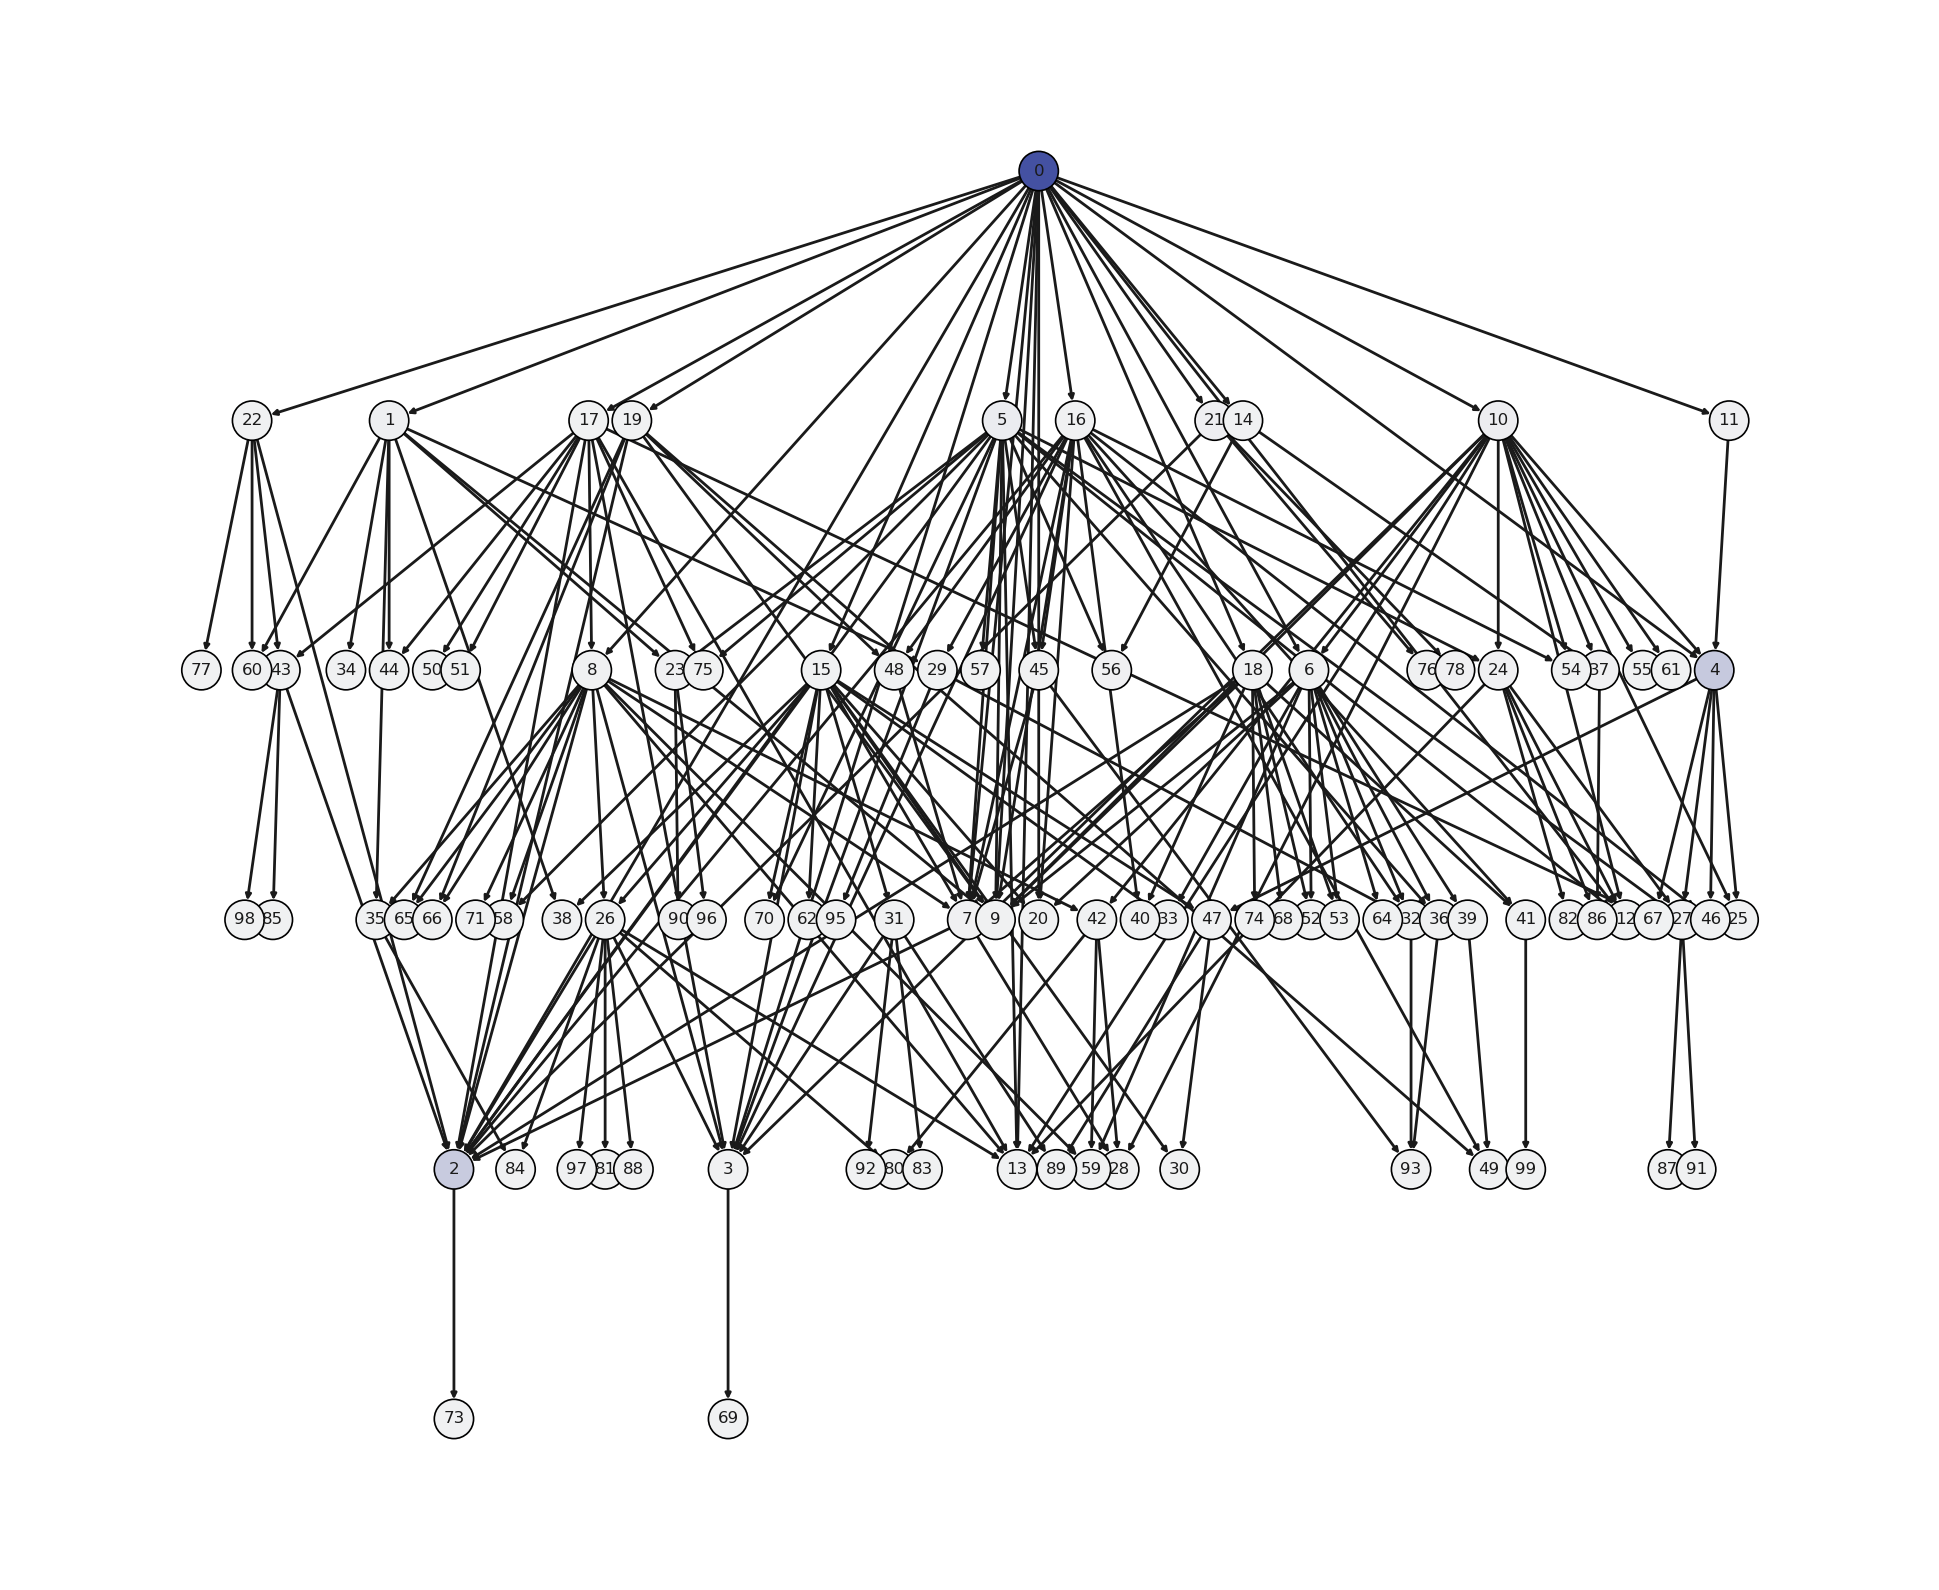

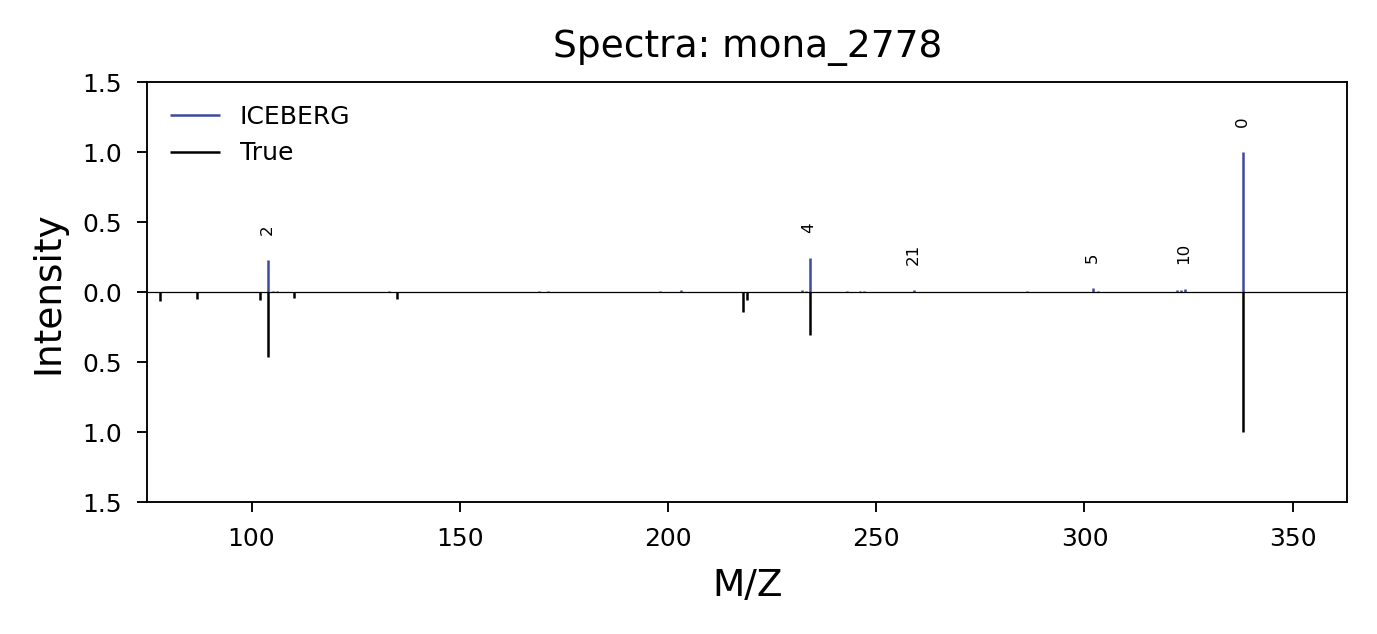

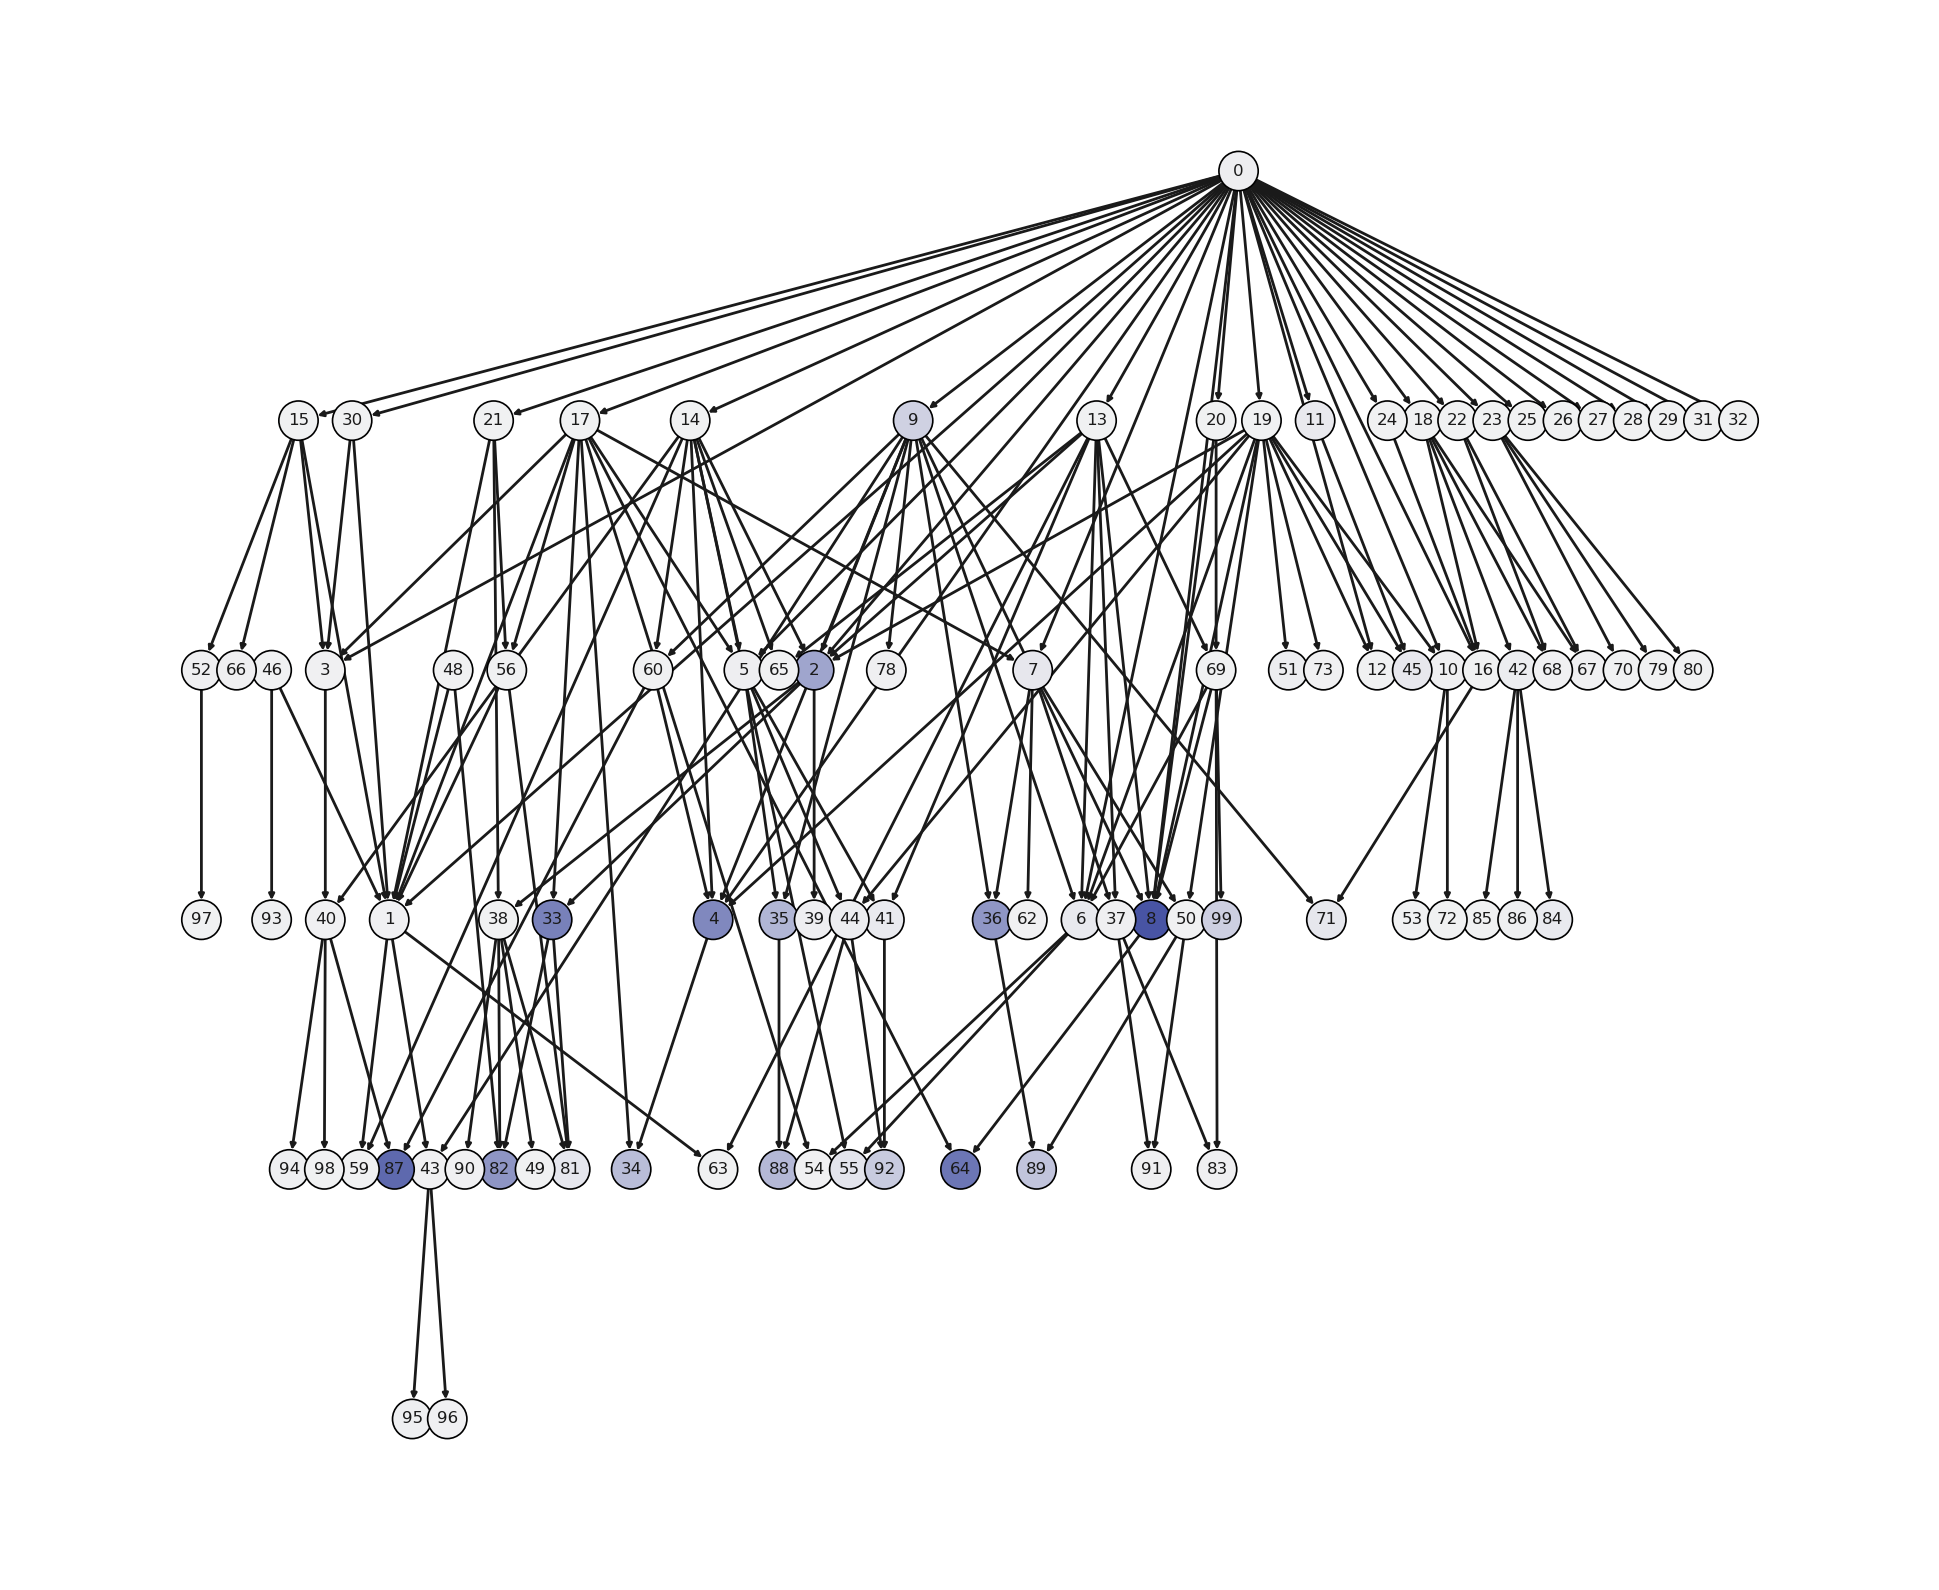

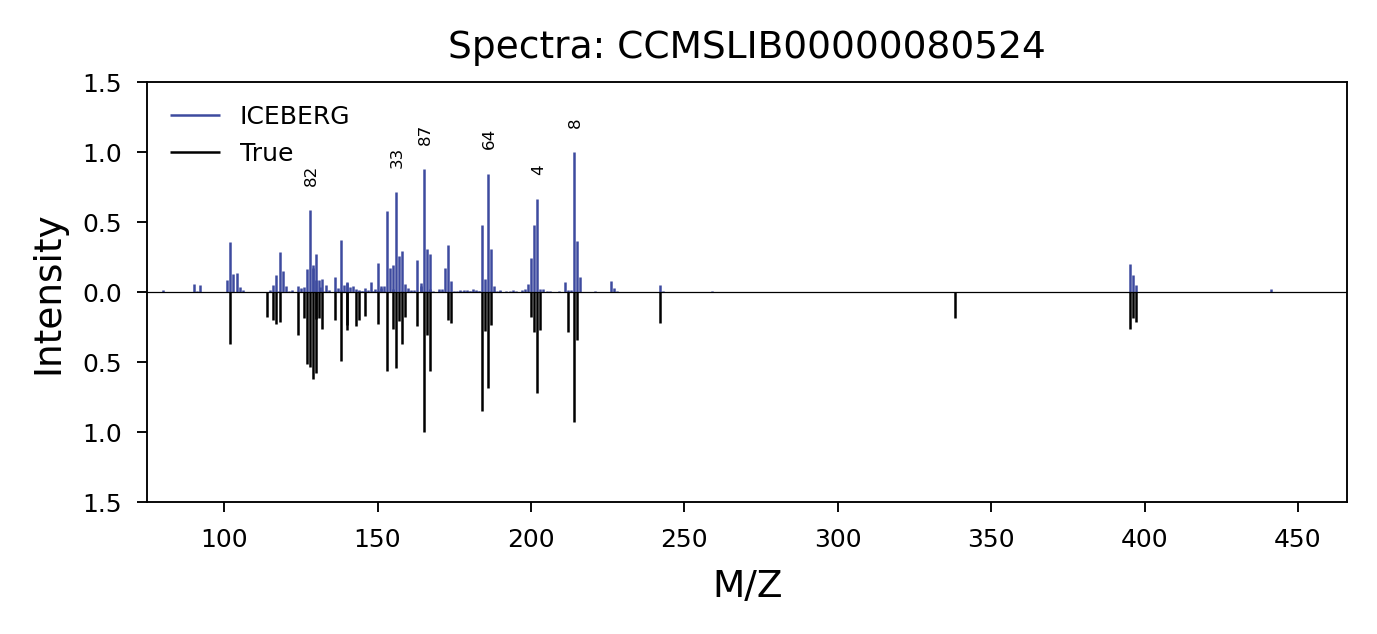

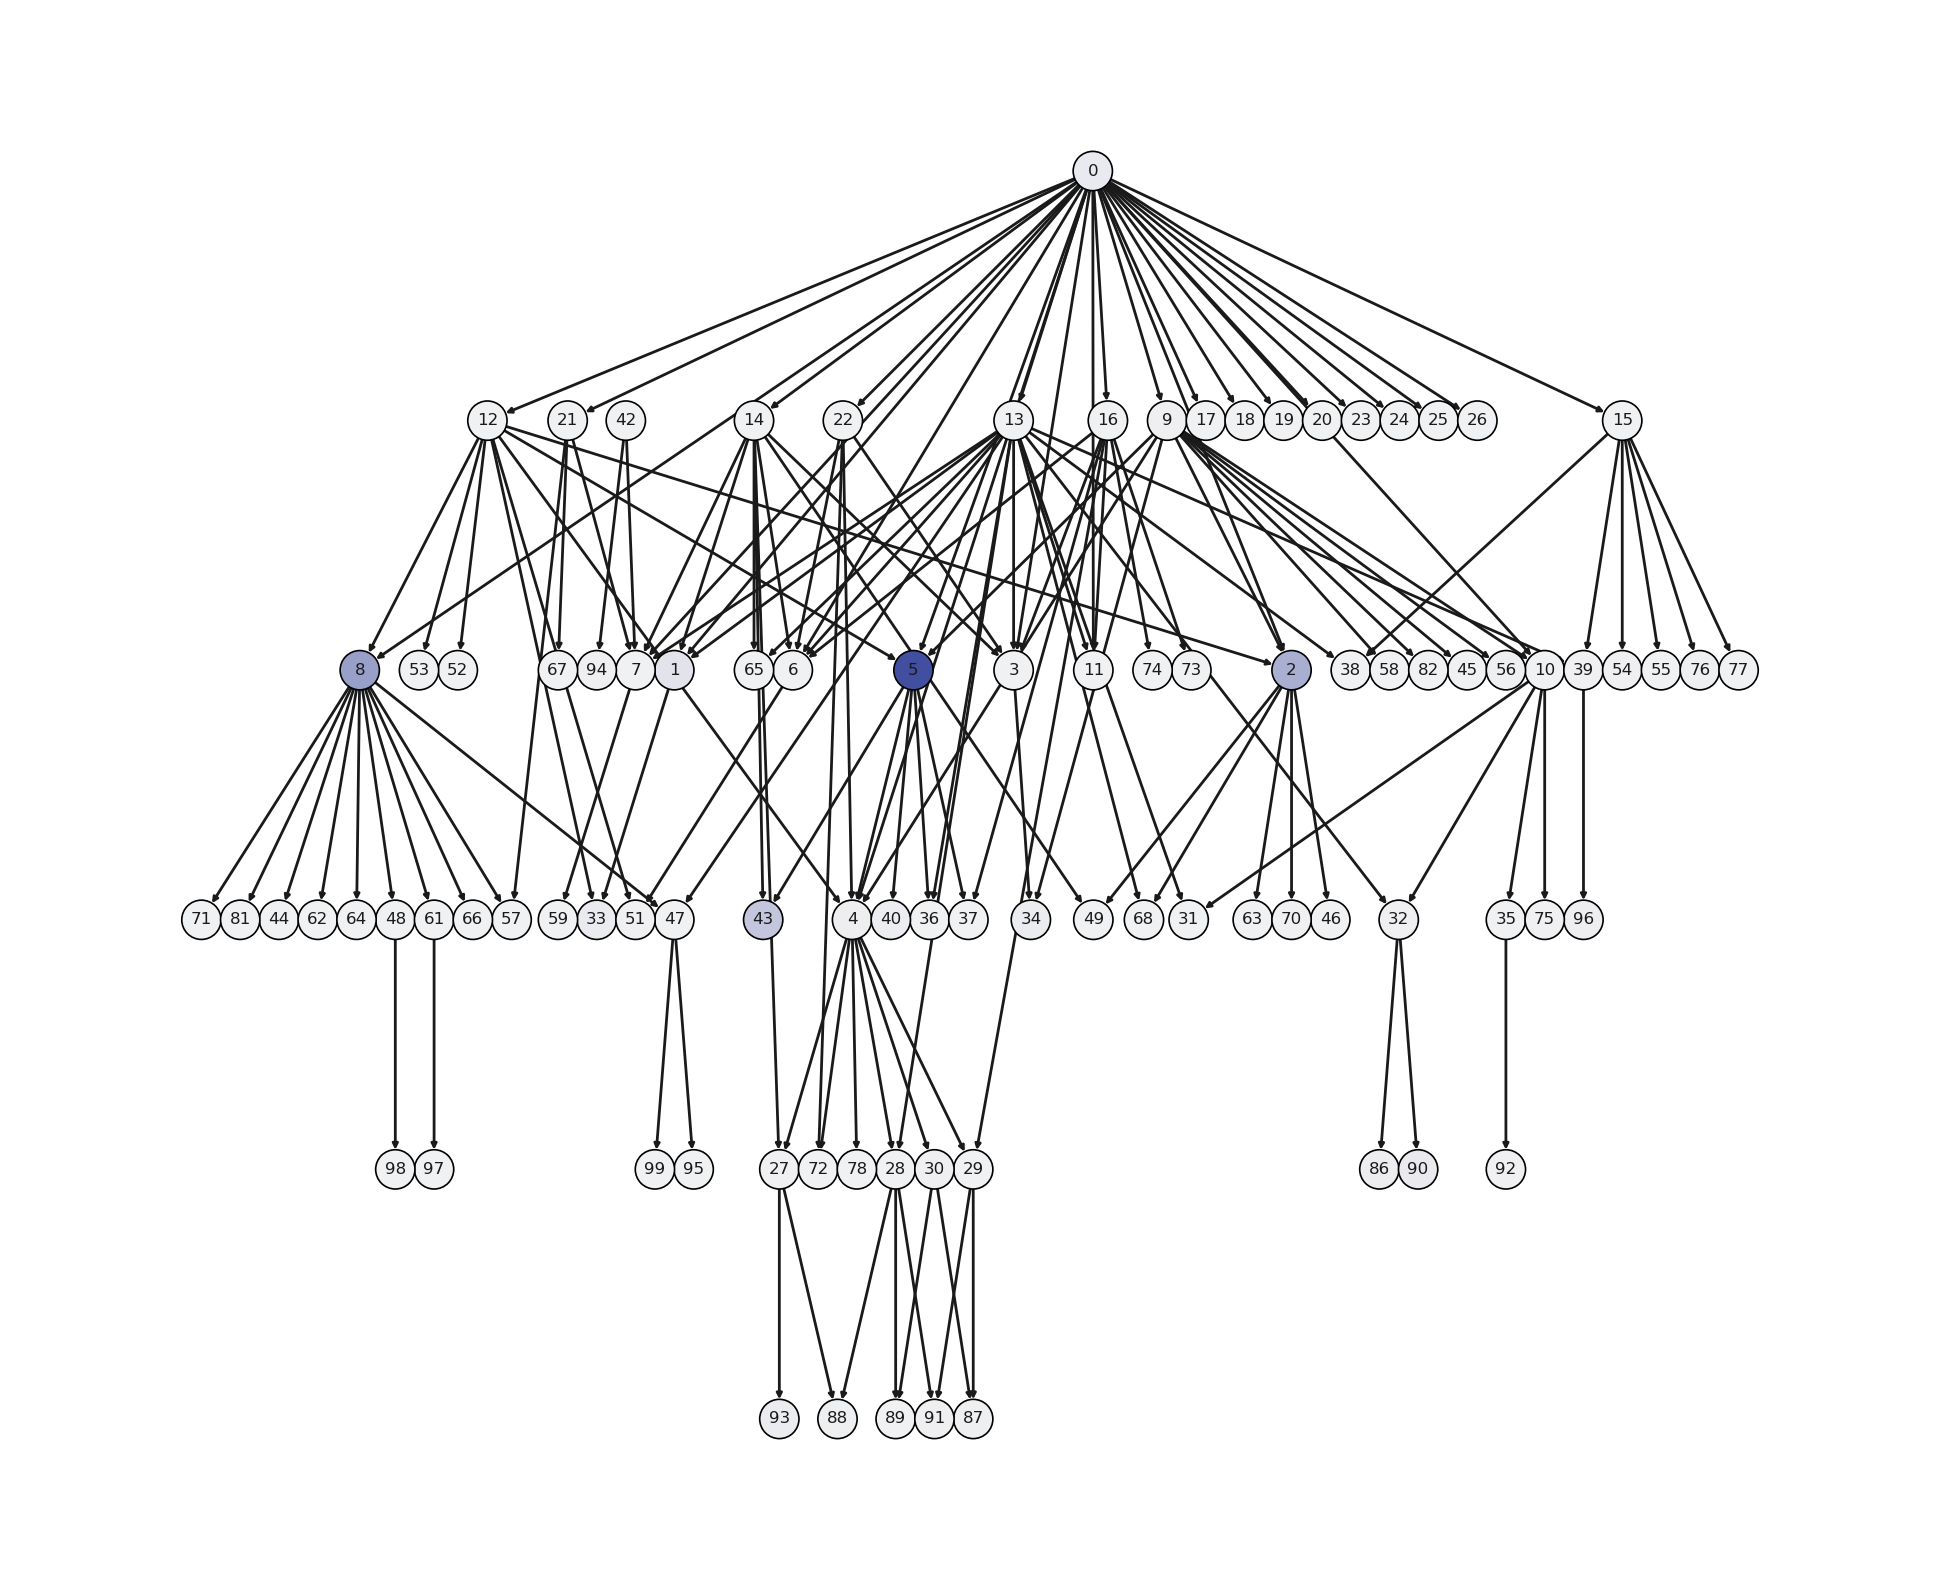

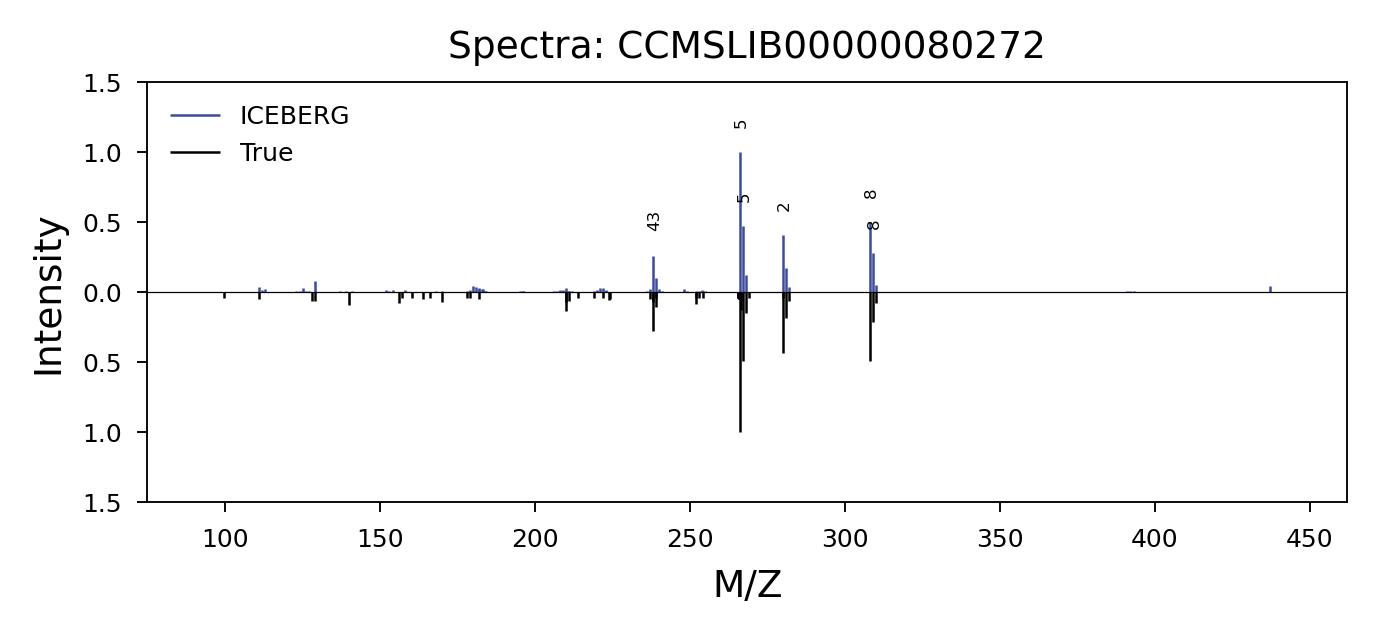

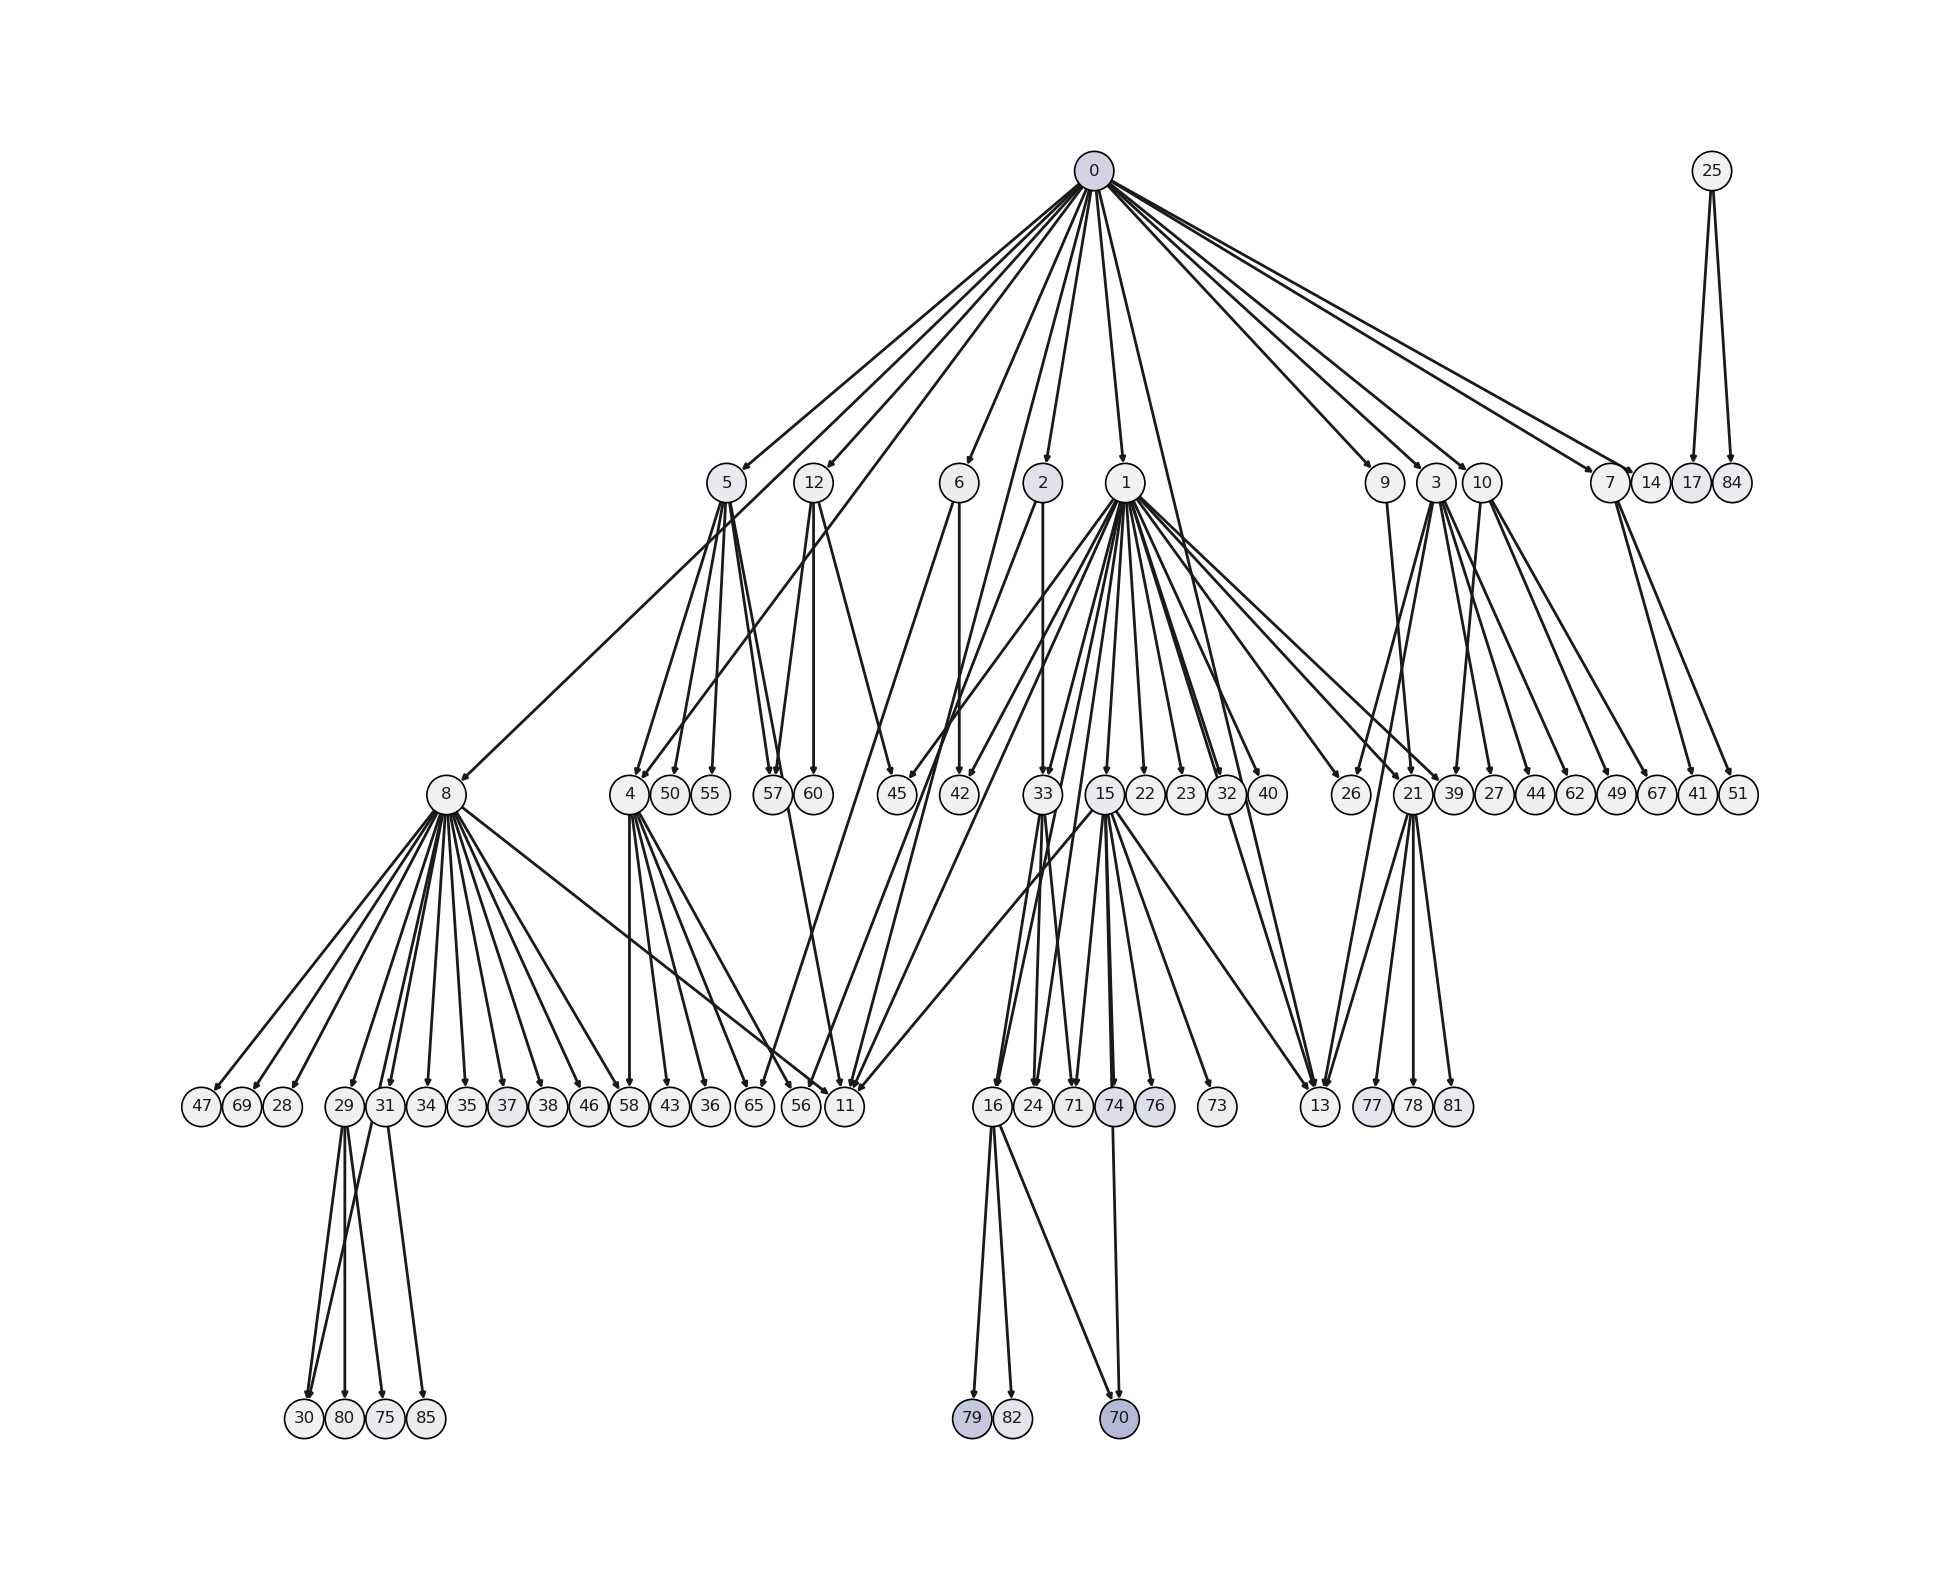

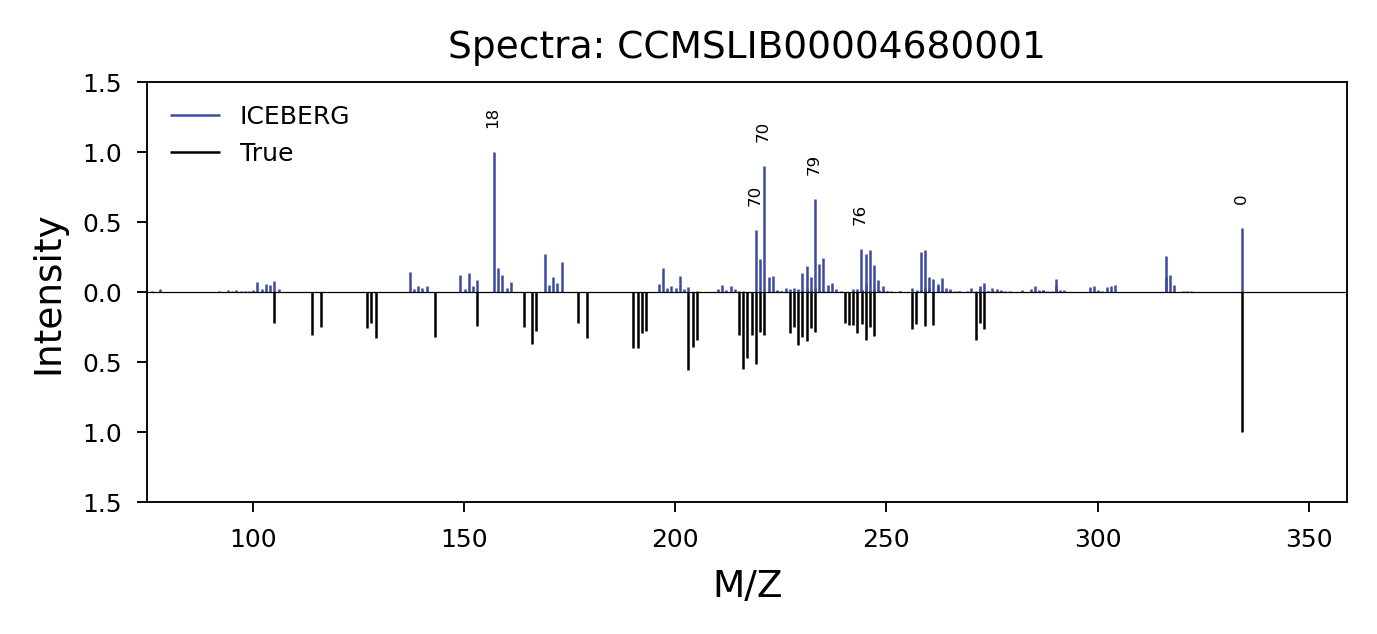

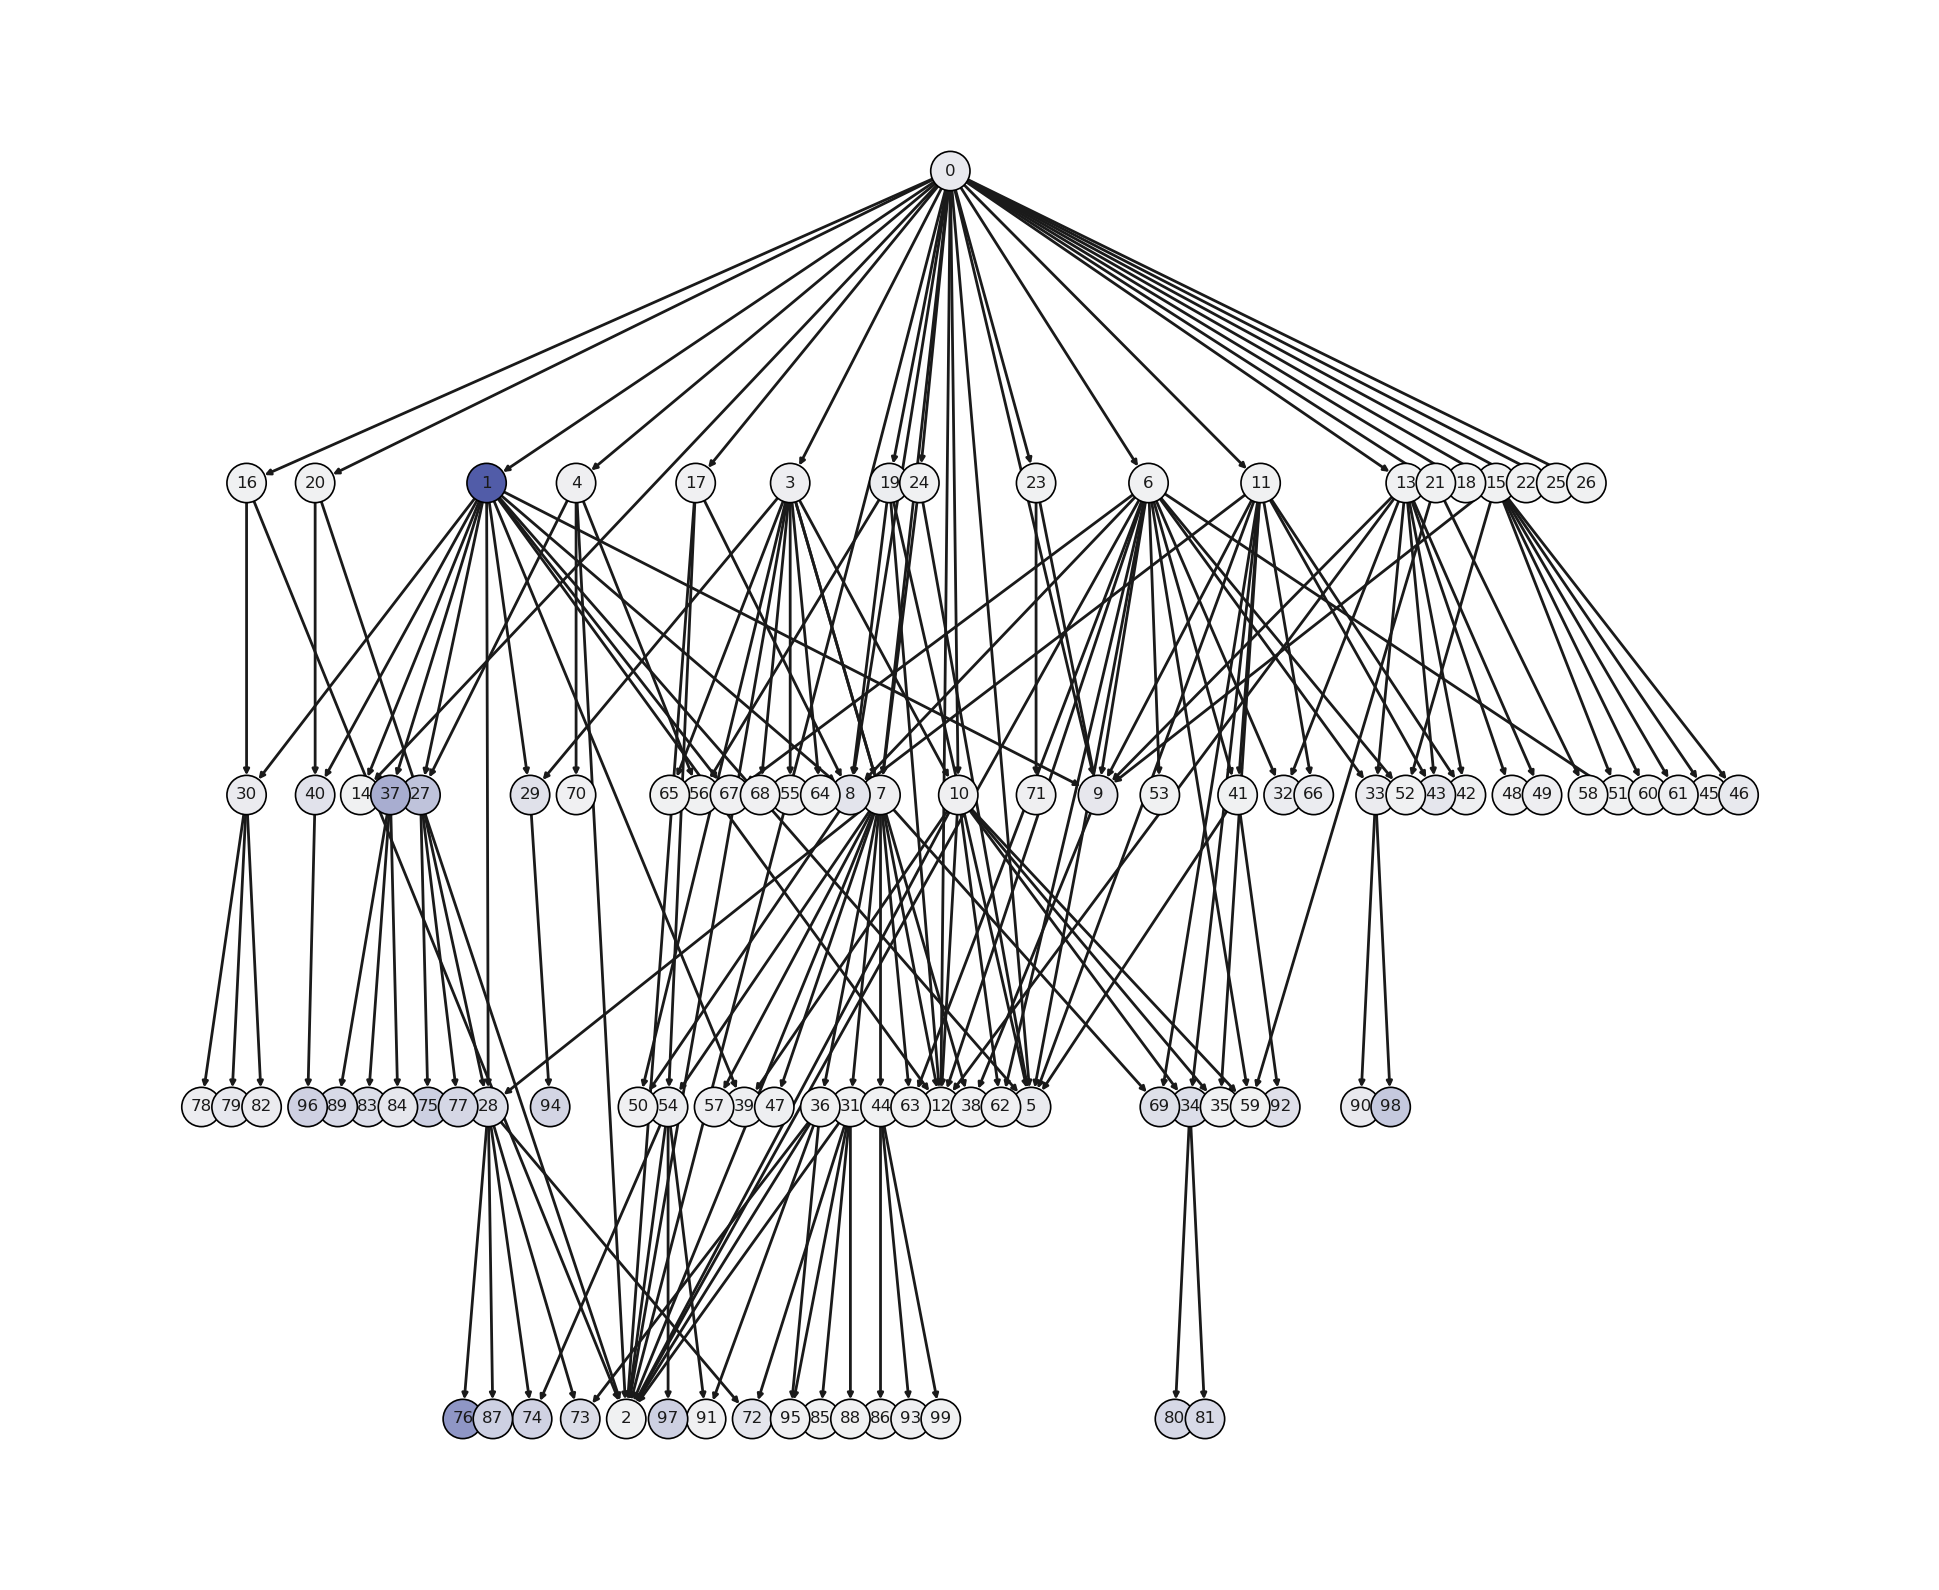

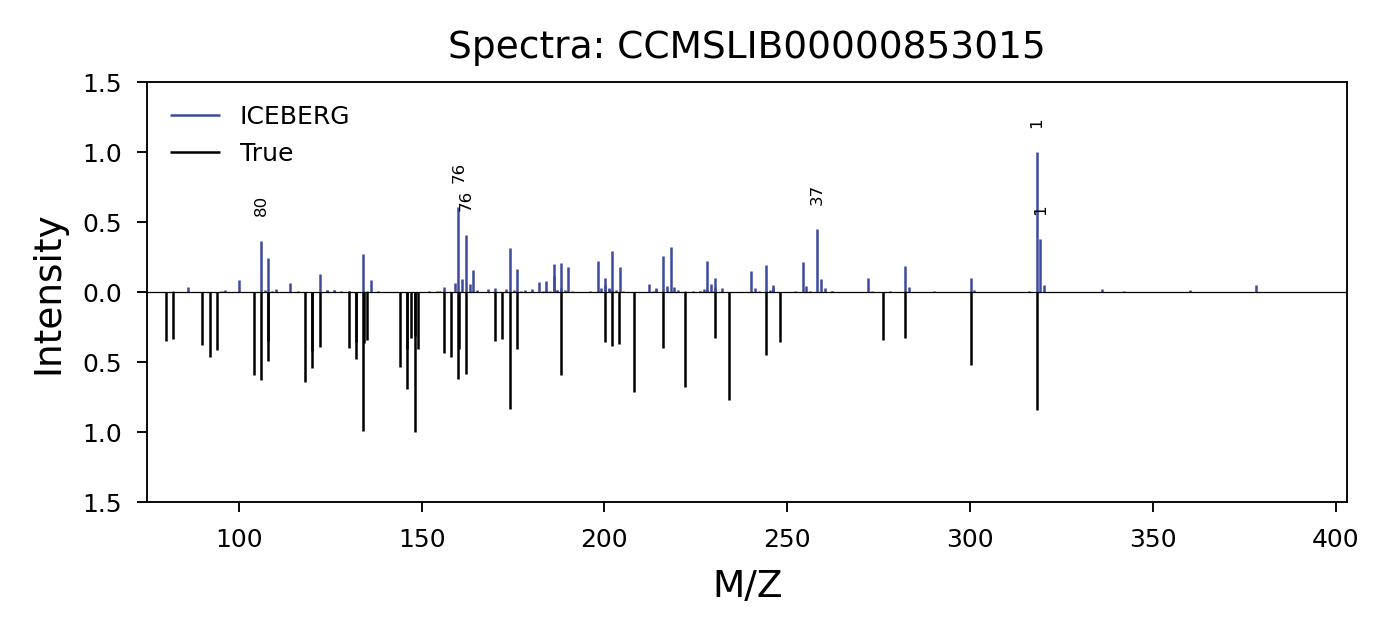

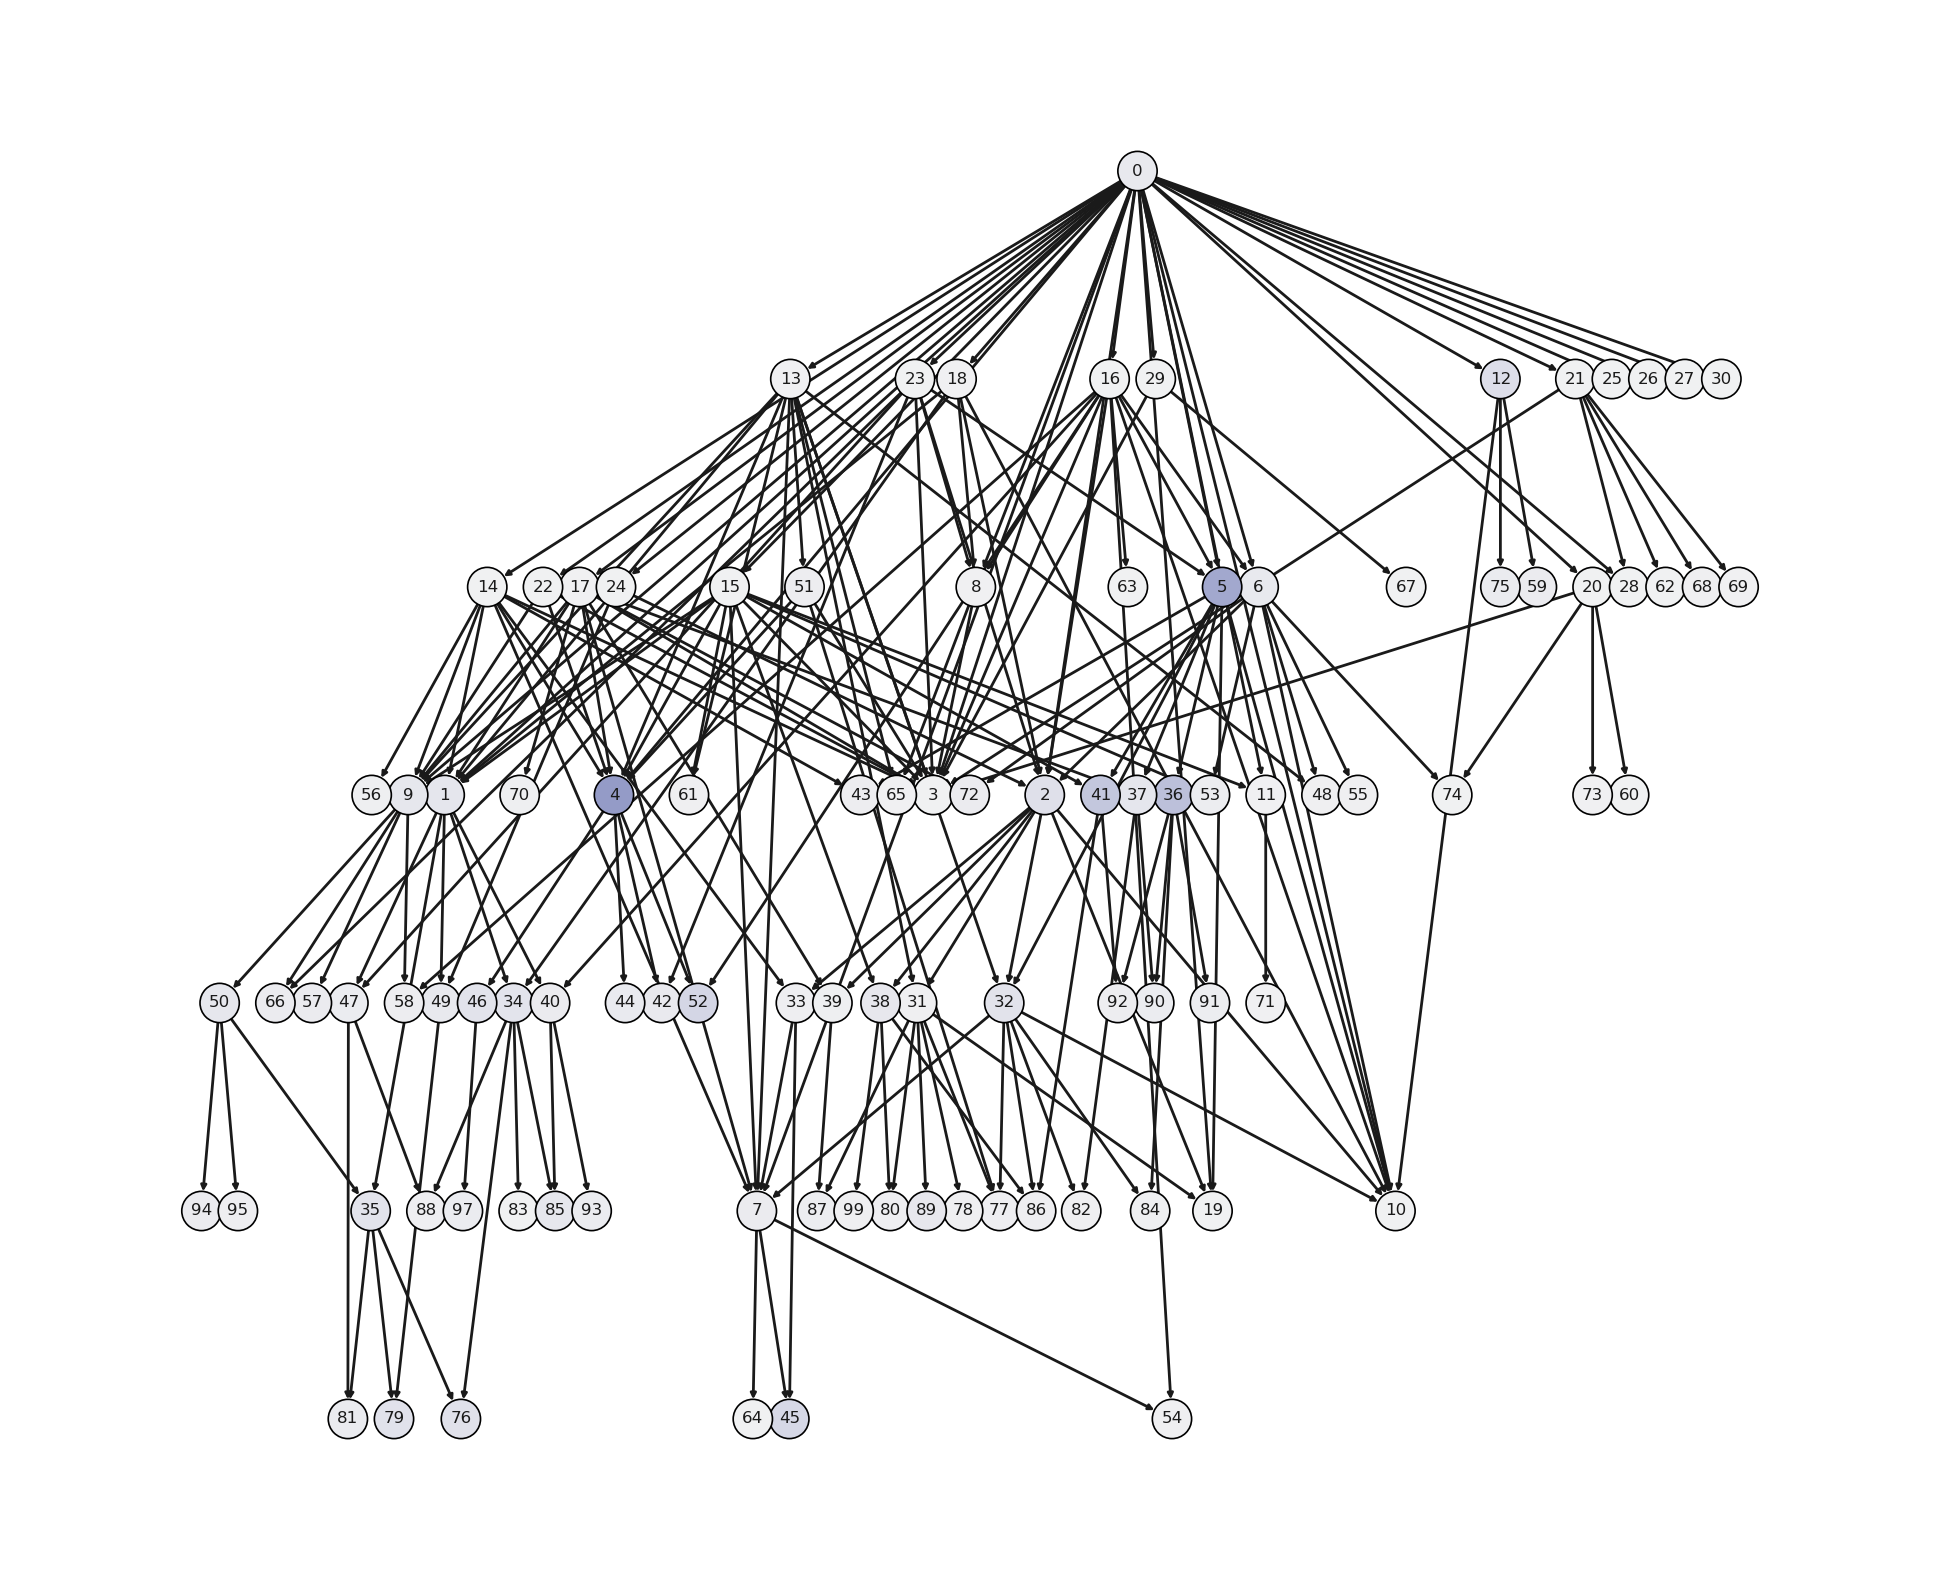

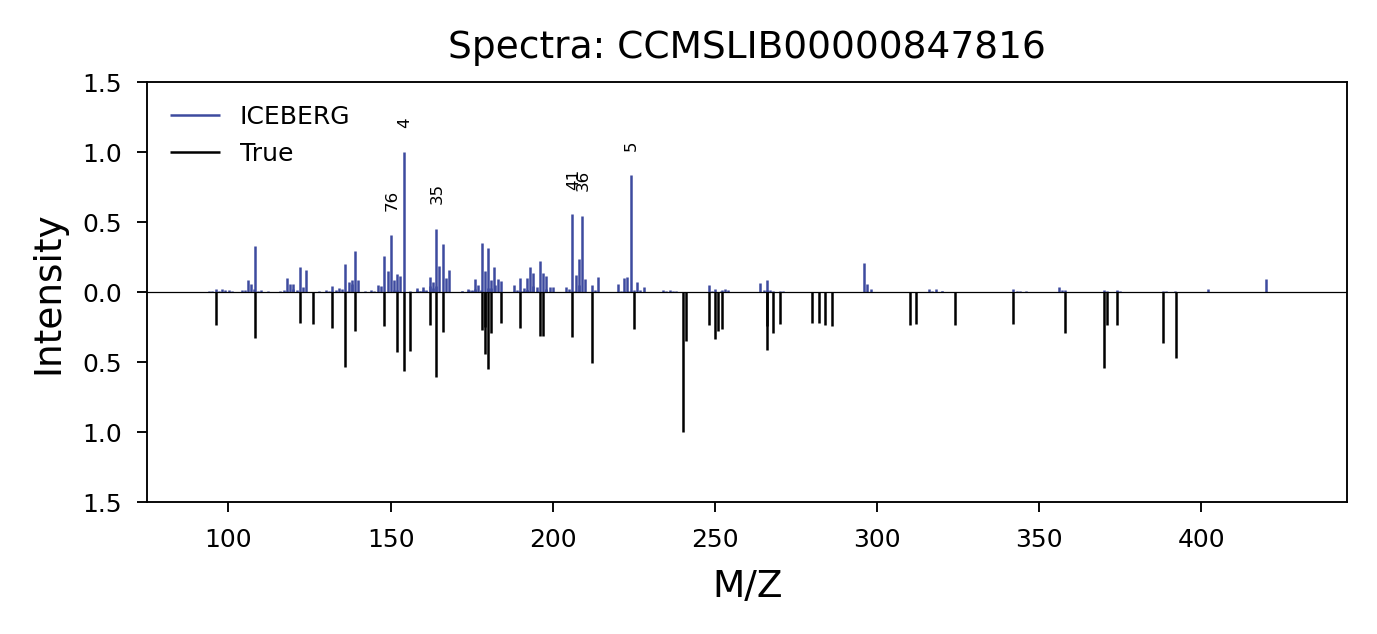

In [7]:
num_sample = 10
# Define results folder for all qualitative results
results_folder = Path(f"../results/figs_iceberg/qualitative/")
results_folder.mkdir(exist_ok=True)
np.random.seed(1)
for ind in np.random.choice(len(test_labels_df), num_sample):
    example_entry = test_labels_df.iloc[ind]

    spec_name = example_entry["spec"]

    # Define results folder for this example
    example_folder = results_folder / spec_name
    example_folder.mkdir(exist_ok=True)

    # Predict example entry
    outputs = model.predict_mol(
        smi=example_entry["smiles"],
        adduct=example_entry["ionization"],
        device="cpu",
        max_nodes=100,
        binned_out=False,
        threshold=0,
    )
    Chem.MolFromSmiles(example_entry["smiles"])

    # Dump to file
    root_inchi = outputs["root_inchi"]
    frags = outputs["frags"]
    engine = fe.FragmentEngine(mol_str=root_inchi, mol_str_type="inchi")
    frag_to_id, id_to_frag = fe.create_new_ids(frags)

    # Dump output to file
    with open(example_folder / "outputs.json", "w") as f:
        json.dump(outputs, f)

    # Create export network viz
    export_network_viz(frags, frag_to_id, id_to_frag, example_folder)

    # Export all frag mols
    export_frag_mols(frags, frag_to_id, engine, example_folder, top_k=10)

    # Export actual spec
    figsize = (4, 1.4)
    top_k = 6
    add_numbers = True

    # Draw spec
    ex_spec = spec_name
    spec_file = data_folder / f"subformulae/no_subform/{ex_spec}.json"
    true_spec = json.load(open(spec_file, "r"))

    # Convert the fragment json to an int ensity list
    new_list = engine.frags_to_intens(frags)
    new_list = [dict(id=frag_to_id[i["frag_hash"]], **i) for i in new_list]

    draw_fig(
        new_list=new_list,
        true_spec=true_spec,
        example_folder=example_folder,
        ex_spec=ex_spec,
        frag_to_id=frag_to_id,
        engine=engine,
        figsize=figsize,
        top_k=top_k,
        add_numbers=add_numbers,
        linewidth=0.6,
    )
    # print(sorted(new_list, key=lambda x: x['inten'])[-1])